In [793]:
import yaml
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
import numpy as np
import os
import pandas as pd
import json
import scipy
import rasterio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.spatial import distance
from matplotlib.ticker import ScalarFormatter
import math
from scipy.optimize import curve_fit
import cv2
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import ttest_rel
from rasterio.transform import xy
from math import radians, cos, sin, sqrt, atan2
from rasterio.transform import Affine
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import pickle
import h5py
from matplotlib import font_manager as fm
import feather
import json

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['boxplot.medianprops.color'] = 'black'


In [2]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

## 會用到的函數

In [3]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
        
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance

def plot_ellipse(center, covariance, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    在给定的轴上绘制一个椭圆。

    :param center: 椭圆的中心点。
    :param covariance: 椭圆的协方差矩阵。
    :param ax: matplotlib 轴对象。
    :param n_std: 确定椭圆大小的标准差倍数。
    :param facecolor: 椭圆的填充颜色。
    :param kwargs: 传递给 Ellipse 对象的其他参数。
    """
    # 计算协方差矩阵的特征值和特征向量
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # 计算椭圆的宽度和高度
    width, height = 2 * n_std * np.sqrt(eigenvals)
    angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

    # 创建并添加椭圆形状
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    
def png_operation(rst):
    grid_normalized = cv2.normalize(rst, None, 0, 255, cv2.NORM_MINMAX)
    grid_uint8 = grid_normalized.astype(np.uint8)
    colored_image = cv2.applyColorMap(grid_uint8, cv2.COLORMAP_JET)
    # 設定要調整的尺寸，例如 300x300
    new_size = (300, 300)
    # 調整 PNG 的大小
    resized_png = cv2.resize(colored_image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_png

# 計算兩個經緯度點之間的距離，支持向量化操作
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑，單位：公里
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c
def create_figure_mm(width_mm, height_mm, dpi=100):
    """
    根據毫米為單位的寬度和高度創建圖形
    :param width_mm: 寬度（以毫米為單位）
    :param height_mm: 高度（以毫米為單位）
    :param dpi: 圖形的分辨率（每英寸的點數）
    :return: fig, ax 圖形和軸對象
    """
    width_inch = width_mm / 25.4  # 將寬度從毫米轉換為英寸
    height_inch = height_mm / 25.4  # 將高度從毫米轉換為英寸
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
    return fig, ax
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
def get_chinese_sciname(target_name):
    change_names = {
    'Anas_zonorhyncha': 'Anas_poecilorhyncha', 
    'Cyanoderma_ruficeps': 'Stachyridopsis_ruficeps', 
    'Erythrogenys_erythrocnemis': 'Pomatorhinus_erythrocnemis', 
    'Ictinaetus_malaiensis': 'Ictinaetus_malayensis', 
    'Lewinia_striata': 'Gallirallus_striatus', 
    'Machlolophus_holsti': 'Parus_holsti', 
    'Pterorhinus_poecilorhynchus': 'Garrulax_poecilorhynchus', 
    'Pterorhinus_ruficeps': 'Garrulax_ruficeps', 
    'Schoeniparus_brunneus': 'Alcippe_brunnea', 
    'Sittiparus_castaneoventris': 'Poecile_varius', 
    'Synoicus_chinensis': 'Coturnix_chinensis', 
    'Taenioptynx_brodiei': 'Glaucidium_brodiei', 
    'Tarsiger_formosanus': 'Tarsiger_indicus', 
    'Turdus_niveiceps': 'Turdus_poliocephalus', 
    'Zapornia_fusca': 'Porzana_fusca'
    }
    df_name = pd.read_csv('../2023臺灣鳥類名錄-20230419.csv')
    for (new_name, orig_name) in change_names.items():
        if target_name == orig_name:
            target_name = new_name
            
    df_target = df_name[df_name['學名'] == target_name.replace('_', ' ')]
    return df_target['中文名'].values[0]
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

In [595]:
# create a plot folder of the specific exp_id
plot_path = os.path.join('plots', run_id)
plot_path_df = os.path.join(plot_path, 'Fig4_dataframe')
plot_path_nichespace = os.path.join(plot_path, 'Fig4_niche_space')
plot_path_ecogeo_basedonDeepSDMpred = os.path.join(plot_path, 'Fig6_EcoGeo_comparison_basedonDeepSDMpred')
create_folder(plot_path_ecogeo_basedonDeepSDMpred)
plot_path_biotop = os.path.join(plot_path, 'Fig6_biotop')
create_folder(plot_path_biotop)
plot_path_subplots = os.path.join(plot_path, 'Fig6_subplots')
create_folder(plot_path_subplots)
plot_path_nichespace_h5 = os.path.join(plot_path_nichespace, 'h5')
plot_path_responsecurve = os.path.join(plot_path, 'Fig6_responsecurve')
create_folder(plot_path_responsecurve)

In [5]:
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
with open(os.path.join(predicts_path, 'DeepSDM_conf.yaml'), 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))

with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

with open(os.path.join(predicts_path, 'env_inf.json'), 'r') as f:
    env_inf = json.load(f)
    
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    extent_binary = f.read(1)
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    crs = f.crs
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    extent_binary = f.read(1)
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]

In [6]:
deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [7]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])
date_list_train = DeepSDM_conf.training_conf['date_list_train']
date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
env_list = DeepSDM_conf.training_conf['env_list']

In [8]:
with open(os.path.join(plot_path_df, 'extent_info.yaml'), 'rb') as f:
    extent_info = yaml.load(f, yaml.FullLoader)
df_grid = feather.read_dataframe(os.path.join(plot_path_df, 'df_grid.feather'))
df_env_value = feather.read_dataframe(os.path.join(plot_path_df, 'env_value.feather'))
df_spearman_pre = pd.read_csv(os.path.join(plot_path_nichespace, 'spearman_info_basedonDeepSDMpred.csv'))

In [845]:
env_list_change = {
    'clt': 'Cloud area fraction',
    'hurs': 'Relative humidity',
    'pr': 'Precipitation',
    'rsds': 'Shortwave radiation',
    'sfcWind': 'Wind speed',
    'tas': 'Temperature',
    'EVI': 'EVI',
    'landcover_PC00': 'LandcoverPC1',
    'landcover_PC01': 'LandcoverPC2',
    'landcover_PC02': 'LandcoverPC3',
    'landcover_PC03': 'LandcoverPC4',
    'landcover_PC04': 'LandcoverPC5', 
}

# 把全部的圖畫在一起

In [9]:
# 設置字體為 Noto Sans CJK
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 檢查該路徑是否存在
font_prop = fm.FontProperties(fname=font_path, size = 30)

/home/klok0126/.local/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


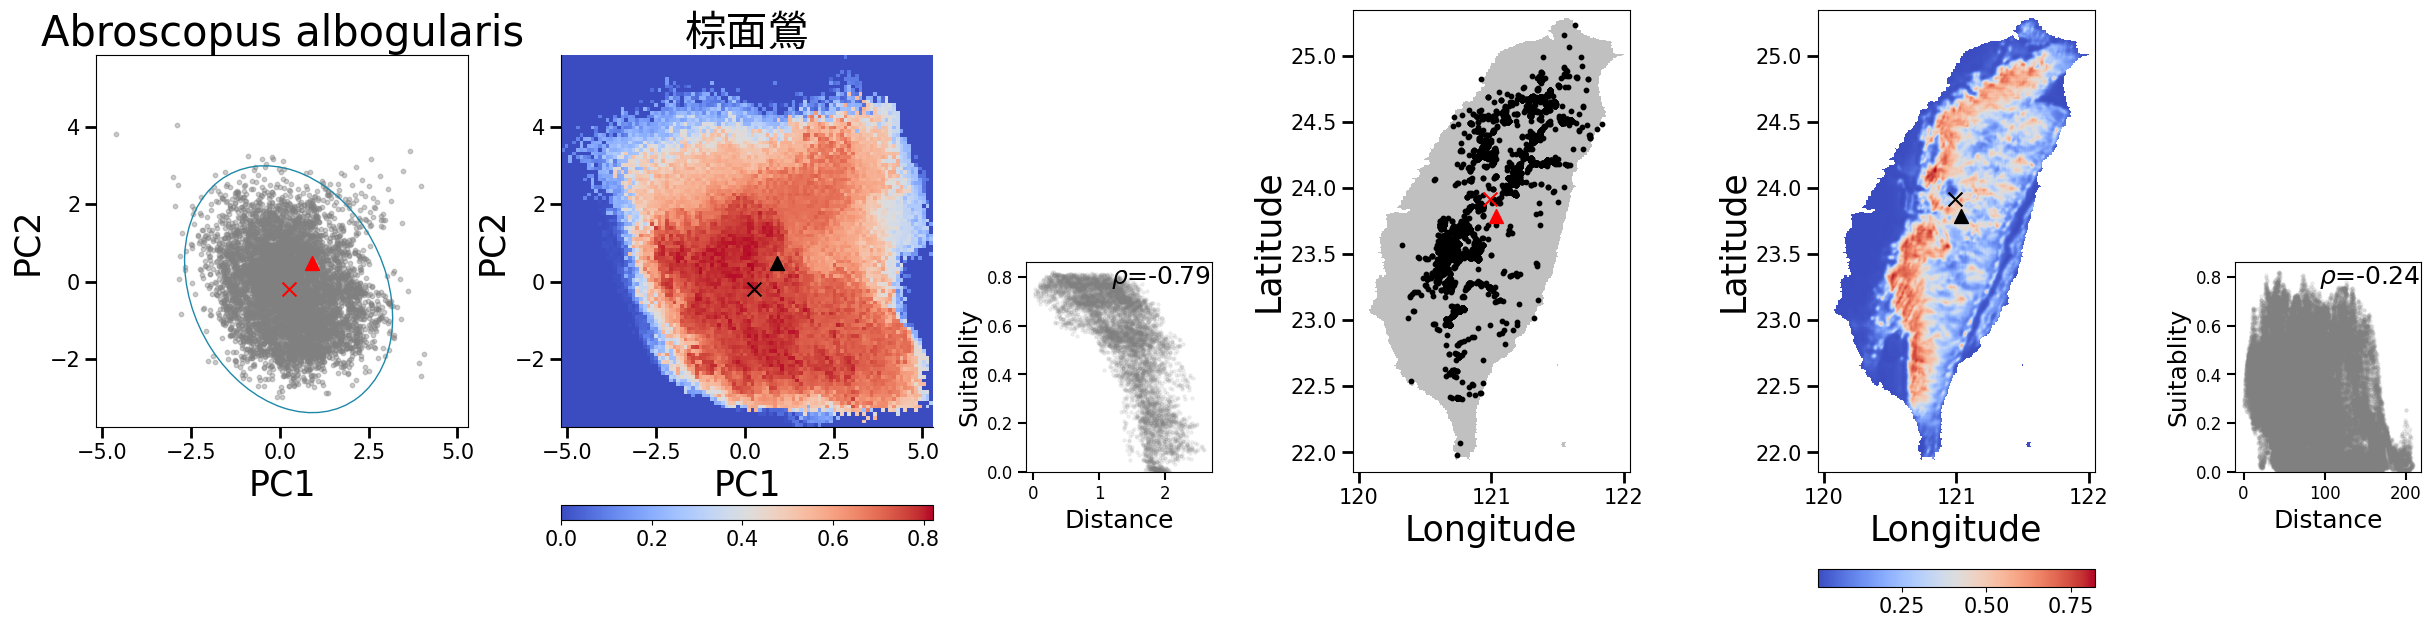

In [28]:
# Select which PC-axis would be plotted
x_pca = 1
y_pca = 2
niche_rst_size = 100
extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
          extent_info[f'PC{x_pca:02d}_extent_max'], 
          extent_info[f'PC{y_pca:02d}_extent_min'], 
          extent_info[f'PC{y_pca:02d}_extent_max']]

df_spearman = pd.DataFrame({'center_type': [], 'species': [], 'rho': [], 'p': []})

# 創建所有像素的網格坐標 (僅執行一次)
x_indices = np.where(extent_binary == 1)[1]
y_indices = np.where(extent_binary == 1)[0]

# 使用 rasterio 的批量處理一次性將像素索引轉換為經緯度
lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
lons, lats = zip(*lon_lat_pairs)
lons = np.array(lons)
lats = np.array(lats)

for species in species_list_predict:
#     species = 'Acridotheres_cristatellus'
    x_all = []
    y_all = []

    # 找到所有的訓練時間點
    for time in date_list_predict:
        img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        
        # 讀取 TIFF 圖像
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
        
        # 找到所有值為1的像素位置
        y_coords = np.where(img == 1)[0]
        x_coords = np.where(img == 1)[1]
        
        # 將 x 和 y 坐標分別添加到列表中
        x_all.extend(x_coords)
        y_all.extend(y_coords)

    # 計算 x 和 y 坐標的平均值，即為重心
    x_center_real = np.mean(x_all)
    y_center_real = np.mean(y_all)

    # 使用仿射變換矩陣將重心像素坐標轉換為地理坐標
    lon_center_real, lat_center_real = rasterio.transform.xy(transform, y_center_real, x_center_real, offset='center')

    img_sum = None  # 用於累加所有時間點的圖像

    with h5py.File(deepsdm_h5_path.replace('[SPECIES]', species), 'r') as hf:
        for date in date_list_predict:
            if img_sum is None:
                img_sum = hf[date][:].copy()
            else:
                img_sum = np.maximum(img_sum, hf[date][:].copy())
    
    # 儲存影像
    metadata = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,  # Number of bands
        "dtype": "float64",
        "crs": crs,
        "transform": transform,
    }   
    
    # 計算每個像素與地理重心之間的距離，使用批量化的 numpy 操作
    lon_center, lat_center = rasterio.transform.xy(transform, 
                                                   (np.where(~np.isnan(img_sum))[0] * img_sum[~np.isnan(img_sum)]).sum() / img_sum[~np.isnan(img_sum)].sum(), 
                                                   (np.where(~np.isnan(img_sum))[1] * img_sum[~np.isnan(img_sum)]).sum() / img_sum[~np.isnan(img_sum)].sum(), 
                                                   offset='center')    
    distances_all = haversine(lats, lons, lat_center, lon_center)

    # 平展 img_sum 以與 distances_all 一一對應
    cell_values_all = img_sum[~np.isnan(img_sum)].flatten()
    
    # 統計
    rho_geo, p_geo = scipy.stats.spearmanr(distances_all, cell_values_all)
    df_spearman.loc[len(df_spearman)] = ['Geographical_basedonDeepSDMpred', species, rho_geo, p_geo]


    df_species = pd.read_pickle(os.path.join(plot_path_df, f'{species}.pkl'))
    df_species = pd.concat([df_species, df_grid], axis = 1)
    
    with rasterio.open(os.path.join(plot_path_nichespace, f'{species}_deepsdm_all_season_nichespace_max.tif'), 'r') as f:
        nichespace_deepsdm = f.read(1)

    fig = plt.figure(figsize = (30, 6))
    gs = gridspec.GridSpec(2, 6, width_ratios = [1, 1, 0.5, 1, 1, 0.5], height_ratios = [1, 1], wspace = 0.3)
    ax1 = fig.add_subplot(gs[0:2, 0])
    ax2 = fig.add_subplot(gs[0:2, 1])
    ax3 = fig.add_subplot(gs[0:2, 3])
    ax4 = fig.add_subplot(gs[0:2, 4])
    ax_eco_cph = fig.add_subplot(gs[1, 2])
    ax_geo_cph = fig.add_subplot(gs[1, 5])


    pcaxy = {'x': list(), 'y': list()}
    for d in date_list_train:
        if f'occ_{species}_{d}' in df_species:
            i_p = df_species[f'occ_{species}_{d}'] == 1
            ax1.scatter(df_env_value[f'PC{x_pca:02d}_{d}'][i_p], df_env_value[f'PC{y_pca:02d}_{d}'][i_p], c = 'grey', alpha = 0.4, s = 10)
            pcaxy['x'] = pcaxy['x'] + list(df_env_value[f'PC{x_pca:02d}_{d}'][i_p])
            pcaxy['y'] = pcaxy['y'] + list(df_env_value[f'PC{y_pca:02d}_{d}'][i_p])
    # ax1.spines['right'].set_visible(False)
    # ax1.spines['top'].set_visible(False)
    ax1.set_ylabel('PC2', fontsize = 25)
    ax1.set_xlabel('PC1', fontsize = 25)
    ax1.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
    ax1.tick_params(axis='both', which='both', length=8, width=2)  # 調整長度和寬度
    ax1.set_title(f'{species.replace("_", " ")}', fontsize = 30)

    if len(pcaxy['x']) <= 2:
        continue
    center_real, covariance = cov_center(np.column_stack((pcaxy['x'], pcaxy['y'])), level=0.95)
    plot_ellipse(center_real, covariance, ax=ax1, edgecolor='#1E88A8', n_std = 3.0)
    
    # calculate the negative regression of every cell of 2d-niche space to the niche center
    # 计算每个单元格的宽度和高度
    cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
    cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]

    # 遍历每个单元格以计算中心点坐标
    coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  #center_x
            coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2) # center_y
            coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])  # value_deepsdm

    df_cor = pd.DataFrame(coordinates_values).query('value_deepsdm > 0').reset_index(drop = True)    
    df_cor_only = df_cor.loc[df_cor['value_deepsdm'] > 0, ['center_x', 'center_y']].reset_index(drop = True)

    # 假設這是整個數據集的協方差矩陣
    cov_matrix = np.cov(df_cor_only, rowvar=False)

    # 計算協方差矩陣的逆矩陣
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # 計算加權的中心
    center_x = np.multiply(np.array(coordinates_values['center_x']), np.array(coordinates_values['value_deepsdm'])).sum() / np.array(coordinates_values['value_deepsdm']).sum()
    center_y = np.multiply(np.array(coordinates_values['center_y']), np.array(coordinates_values['value_deepsdm'])).sum() / np.array(coordinates_values['value_deepsdm']).sum()
    center = np.array([center_x, center_y])

    # 計算 Mahalanobis 距離
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)    
    condition_deepsdm = df_cor['value_deepsdm'] > 0
    rho_eco, p_eco = scipy.stats.spearmanr(df_cor['distance_mah'][condition_deepsdm], df_cor['value_deepsdm'][condition_deepsdm])
    
    df_spearman.loc[len(df_spearman)] = ['Ecological_basedonDeepSDMpred', species, rho_eco, p_eco]    
#     text_list =[]
#     for i in range(loadings.shape[0]):
#         ax1.arrow(0, 0, loadings[i, 0]*1.2, loadings[i, 1]*1.2, color='#D0104C', alpha=0.7, lw = 2, head_width = 0.2)
#         text_list.append(ax1.text(loadings[i, 0]*1.3, loadings[i, 1]*1.3, f'{env_list[i]}', color='black', fontsize = 17))
#     adjust_text(text_list, ax = ax1)
#     plot_ellipse(center, covariance, ax=ax1, edgecolor='#1E88A8', n_std = 3.0)
    ax1.scatter(center[0], center[1], c = 'red', s = 100, marker = '^')
    ax1.scatter(center_real[0], center_real[1], c = 'red', s = 100, marker = 'x')

    # 確保 x 和 y 軸等長，調整邊界讓其保持正方形
    xlims = [extent[0], extent[1]]
    ylims = [extent[2], extent[3]]
    ax1.set_xlim(xlims)
    ax1.set_ylim(ylims)
    ax1.set_box_aspect(1)  # 使用 set_box_aspect 來強制 x 和 y 軸等比例顯示，確保正方形

    ax2_imshow = ax2.imshow(nichespace_deepsdm, cmap = 'coolwarm', extent = extent)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel('PC2', fontsize = 25)
    ax2.set_xlabel('PC1', fontsize = 25)
    ax2.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
    ax2.tick_params(axis='both', which='both', length=8, width=2)  # 調整長度和寬度
    ax2.set_title(f'{get_chinese_sciname(species)}', fontproperties = font_prop)
    
    ax2.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])))  # 計算x和y的比例，並設置為等比例
    
    ax2.scatter(center[0], center[1], c = 'black', s = 100, marker = '^')
    ax2.scatter(center_real[0], center_real[1], c = 'black', s = 100, marker = 'x')
    
    ax2_pos = ax2.get_position()
    cbar_ax = fig.add_axes([ax2_pos.x0, 
                            ax2_pos.y0 - ax2_pos.height*0.25, 
                            ax2_pos.width*1, 
                            ax2_pos.height*0.04])
    cbar = fig.colorbar(ax2_imshow, ax = ax2, orientation='horizontal', cax = cbar_ax)
    cbar.ax.tick_params(labelsize=15, which='both')  # 調整刻度標籤字體大小

    
    
    ax3_imshow = ax3.imshow(np.where(extent_binary == 1, extent_binary, np.nan), cmap = ListedColormap(['silver']), extent = extent_binary_extent)
    lon_all, lat_all = rasterio.transform.xy(transform, y_all, x_all, offset='center')
    ax3.scatter(lon_all, lat_all, c = 'black', s = 10)
#     ax3.spines['right'].set_visible(False)
#     ax3.spines['top'].set_visible(False)
    ax3.set_ylabel('Latitude', fontsize = 25)
    ax3.set_xlabel('Longitude', fontsize = 25)
    ax3.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
    ax3.tick_params(axis='both', which='both', length=8, width=2)  # 調整長度和寬度
    ax3.set_title(f'', fontsize = 30)
    ax3.scatter(lon_center, lat_center, c = 'red', s = 100, marker = '^')
    ax3.scatter(lon_center_real, lat_center_real, c = 'red', s = 100, marker = 'x')
        
    # 繪製圖像 (ax4)
    ax4_imshow = ax4.imshow(img_sum, cmap='coolwarm', extent = extent_binary_extent)
#     ax4.spines['right'].set_visible(False)
#     ax4.spines['top'].set_visible(False)
    ax4.set_ylabel('Latitude', fontsize = 25)
    ax4.set_xlabel('Longitude', fontsize = 25)
    ax4.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
    ax4.tick_params(axis='both', which='both', length=8, width=2)  # 調整長度和寬度
    ax4.set_title(f'', fontsize = 30)
    ax4.scatter(lon_center, lat_center, c = 'black', s = 100, marker = '^')
    ax4.scatter(lon_center_real, lat_center_real, c = 'black', s = 100, marker = 'x')
    
    ax4_pos = ax4.get_position()
    cbar_ax = fig.add_axes([ax4_pos.x0, 
                            ax4_pos.y0 - ax4_pos.height*0.25, 
                            ax4_pos.width*1, 
                            ax4_pos.height*0.04])
    cbar = fig.colorbar(ax4_imshow, ax=ax4, orientation='horizontal', cax=cbar_ax)

    # 設定 tick 的字體大小
    cbar.ax.tick_params(labelsize=15, which='both')  # 調整刻度標籤字體大小
    
    # plotting
    # 獲取軸的位置
    ax_geo_cph.scatter(x = distances_all, 
                       y = cell_values_all, 
                       alpha = 0.1, 
                       color = 'grey', 
                       s = 5
                      )
    ax_eco_cph.scatter(x = df_cor['distance_mah'][condition_deepsdm], 
                       y = df_cor['value_deepsdm'][condition_deepsdm], 
                       alpha = 0.1,
                       color = 'grey', 
                       s = 5
                      )


#     ax_eco_cph.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     ax_geo_cph.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     ax_eco_cph.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     ax_geo_cph.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax_eco_cph.tick_params(axis='both', which='both', length=6, width=1.5)  # 調整長度和寬度
    ax_geo_cph.tick_params(axis='both', which='both', length=6, width=1.5)  # 調整長度和寬度
    ax_eco_cph.tick_params(axis='both', labelsize=12)  # 設置 x 軸刻度標籤字體大小
    ax_geo_cph.tick_params(axis='both', labelsize=12)  # 設置 x 軸刻度標籤字體大小
    ax_eco_cph.yaxis.get_offset_text().set_size(15)  # 調整「x 10^n」的字體大小
    ax_geo_cph.yaxis.get_offset_text().set_size(15)  # 調整「x 10^n」的字體大小
    ax_geo_cph.set_ylabel('Suitablity', fontsize = 18)
    ax_geo_cph.set_xlabel('Distance', fontsize = 18)
    ax_eco_cph.set_ylabel('Suitablity', fontsize = 18)
    ax_eco_cph.set_xlabel('Distance', fontsize = 18)
    ax_eco_cph.set_ylim(bottom=0)
    ax_geo_cph.set_ylim(bottom=0)
    
    ax_eco_cph_pos = ax_eco_cph.get_position()
    ax_geo_cph_pos = ax_geo_cph.get_position()
    fig.text(x = ax_geo_cph_pos.x1 - ax_geo_cph_pos.width*0.01, 
             y = ax_geo_cph_pos.y1 - ax_geo_cph_pos.height*0.01, 
             s = rf'$\rho$={rho_geo:.2f}', 
             ha = 'right', 
             va = 'top', 
             fontsize=18)
    fig.text(x = ax_eco_cph_pos.x1 - ax_eco_cph_pos.width*0.01, 
             y = ax_eco_cph_pos.y1 - ax_eco_cph_pos.height*0.01, 
             s = rf'$\rho$={rho_eco:.2f}', 
             ha = 'right', 
             va = 'top', 
             fontsize=18)


    path_out = os.path.join(plot_path_ecogeo_basedonDeepSDMpred, f'{species}_EcoGeo_nichespace_comparison_basedonDeepSDMpred.pdf')
#     plt.show()
#     plt.savefig(path_out, dpi = 200, transparent = False, facecolor='white',  bbox_inches='tight')
    break
#     plt.close()
# df_spearman.to_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'spearman_info_basedonDeepSDMpred.csv'), index = None)

# 分開畫

### 只計算平均圖、rho、p值，不繪圖

In [ ]:
extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
          extent_info[f'PC{x_pca:02d}_extent_max'], 
          extent_info[f'PC{y_pca:02d}_extent_min'], 
          extent_info[f'PC{y_pca:02d}_extent_max']]
# Select which PC-axis would be plotted
x_pca = 1
y_pca = 2

df_spearman = pd.DataFrame({'center_type': [], 'species': [], 'rho': [], 'p': []})

# 讀取任意一個時間點的圖像來初始化 georeferencing 和變換矩陣
initial_img_path = DeepSDM_template.replace('[TIME]', date_list_train[0]).replace('[SPECIES]', species_list[0])
with rasterio.open(initial_img_path) as dataset:
    transform = dataset.transform

# 創建所有像素的網格坐標 (僅執行一次)
x_indices = np.where(~np.isnan(tiff.imread(initial_img_path)))[1]
y_indices = np.where(~np.isnan(tiff.imread(initial_img_path)))[0]

# 使用 rasterio 的批量處理一次性將像素索引轉換為經緯度
lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
lons, lats = zip(*lon_lat_pairs)
lons = np.array(lons)
lats = np.array(lats)

for species in species_list:
    
    x_all = []
    y_all = []

    # 找到所有的訓練時間點
    for time in date_list_train:
        img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        
        # 讀取 TIFF 圖像
        tiff_img = tiff.imread(img_path)
        
        # 找到所有值為1的像素位置
        y_coords = np.where(tiff_img == 1)[0]
        x_coords = np.where(tiff_img == 1)[1]
        
        # 將 x 和 y 坐標分別添加到列表中
        x_all.extend(x_coords)
        y_all.extend(y_coords)

    # 計算 x 和 y 坐標的平均值，即為重心
    x_center = np.mean(x_all)
    y_center = np.mean(y_all)

    # 使用仿射變換矩陣將重心像素坐標轉換為地理坐標
    lon_center, lat_center = rasterio.transform.xy(transform, y_center, x_center, offset='center')

    img_sum = None  # 用於累加所有時間點的圖像

    # 計算所有時間點的平均圖像
    for time in date_list_train:
        img_path = DeepSDM_template.replace('[TIME]', time).replace('[SPECIES]', species)
        tiff_img = tiff.imread(img_path)
        
        if img_sum is None:
            img_sum = tiff_img.astype(np.float64)
        else:
#             img_sum += tiff_img.astype(np.float64)
            img_sum = np.maximum(img_sum, tiff_img.astype(np.float64))
    
    # 儲存影像
#     cv2.imwrite(os.path.join(plot_path_biotop, f'{species}.tif'), img_sum)
    
    # 計算每個像素與地理重心之間的距離，使用批量化的 numpy 操作
    distances_all = haversine(lats, lons, lat_center, lon_center)

    # 平展 img_sum 以與 distances_all 一一對應
    pixel_values_all = img_sum[~np.isnan(img_sum)].flatten()
    
    # 統計
    rho_geo, p_geo = scipy.stats.spearmanr(distances_all, pixel_values_all)
    df_spearman.loc[len(df_spearman)] = ['Geographical', species, rho_geo, p_geo]


    df_species = pd.read_csv(os.path.join(plot_path_df, f'{species}.csv'))
    df_species = pd.concat([df_species, df_grid], axis = 1)
    
    # season
    season_sp_date = [(species, d) for d in date_list_train]
    grid_deepsdm_all_season_all = np.zeros((niche_rst_size, niche_rst_size))
    grid_deepsdm_all_season_count_all = np.zeros((niche_rst_size, niche_rst_size))
    for (sp, d) in season_sp_date:
        
        # calculate grid values
        grouped = df_species.groupby([f'PC{x_pca:02d}_{d}_grid', f'PC{y_pca:02d}_{d}_grid'])
        
        # deepsdm all_season
        grid_deepsdm_all_season = np.zeros((niche_rst_size, niche_rst_size))
        grid_deepsdm_all_season_count = np.zeros((niche_rst_size, niche_rst_size))
        try:
            max_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{species}_{d}'].max()
            sum_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{species}_{d}'].sum()
            mean_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{species}_{d}'].mean()
            count_values_deepsdm_all_season = grouped[f'deepsdm_all_season_{species}_{d}'].count()
            for (x, y), value in max_values_deepsdm_all_season.items():
                grid_deepsdm_all_season[niche_rst_size-1-y, x] = value
            for (x, y), value in count_values_deepsdm_all_season.items():
                grid_deepsdm_all_season_count[niche_rst_size-1-y, x] = value
        except KeyError:
            pass
        grid_deepsdm_all_season_all = np.nanmax([grid_deepsdm_all_season_all, grid_deepsdm_all_season], axis = 0)
#         grid_deepsdm_all_season_all = grid_deepsdm_all_season_all + grid_deepsdm_all_season
        grid_deepsdm_all_season_count_all = grid_deepsdm_all_season_count_all + grid_deepsdm_all_season_count
    
    
    grid_deepsdm_all_season_count_all = np.where(grid_deepsdm_all_season_count_all == 0, 1, grid_deepsdm_all_season_count_all)
#     grid_deepsdm_all_season_all = grid_deepsdm_all_season_all / grid_deepsdm_all_season_count_all
#     grid_deepsdm_all_season_all = grid_deepsdm_all_season_all / grid_deepsdm_all_season_all.sum()

    pcaxy = {'x': list(), 'y': list()}
    for d in date_list_train:
        if f'occ_{sp}_{d}' in df_species:
            i_p = df_species[f'occ_{sp}_{d}'] == 1
            pcaxy['x'] = pcaxy['x'] + list(df_env_value[f'PC{x_pca:02d}_{d}'][i_p])
            pcaxy['y'] = pcaxy['y'] + list(df_env_value[f'PC{y_pca:02d}_{d}'][i_p])


    if len(pcaxy['x']) <= 2:
        continue
    center, covariance = cov_center(np.column_stack((pcaxy['x'], pcaxy['y'])), level=0.95)
    
    # calculate the negative regression of every cell of 2d-niche space to the niche center
    # 计算每个单元格的宽度和高度
    cell_width = (extent[1] - extent[0]) / grid_deepsdm_all_season.shape[1]
    cell_height = (extent[3] - extent[2]) / grid_deepsdm_all_season.shape[0]

    # 遍历每个单元格以计算中心点坐标
    coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  #center_x
            coordinates_values['center_y'].append(extent[2] + i * cell_height + cell_height / 2) # center_y
            coordinates_values['value_deepsdm'].append(grid_deepsdm_all_season_all[i, j])  # value_deepsdm


    df_cor = pd.DataFrame(coordinates_values).query('value_deepsdm > 0').reset_index(drop = True)

    df_cor_only = df_cor.loc[df_cor['value_deepsdm'] > 0, ['center_x', 'center_y']].reset_index(drop = True)

    # 假設這是整個數據集的協方差矩陣
    cov_matrix = np.cov(df_cor_only, rowvar=False)

    # 計算協方差矩陣的逆矩陣
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # 計算 Mahalanobis 距離
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)
#     df_cor['distance_mah'] = df_cor_only.apply(lambda row: np.linalg.norm(row - center), axis=1)

    condition_deepsdm = df_cor['value_deepsdm'] > 0
    rho_eco, p_eco = scipy.stats.spearmanr(df_cor['distance_mah'][condition_deepsdm], df_cor['value_deepsdm'][condition_deepsdm])
    
    # log the regression information
    df_spearman.loc[len(df_spearman)] = ['Ecological', sp, rho_eco, p_eco]

# df_spearman.to_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'df_spearman_ecogeo.csv'))

### 第一張圖：niche空間的散布圖

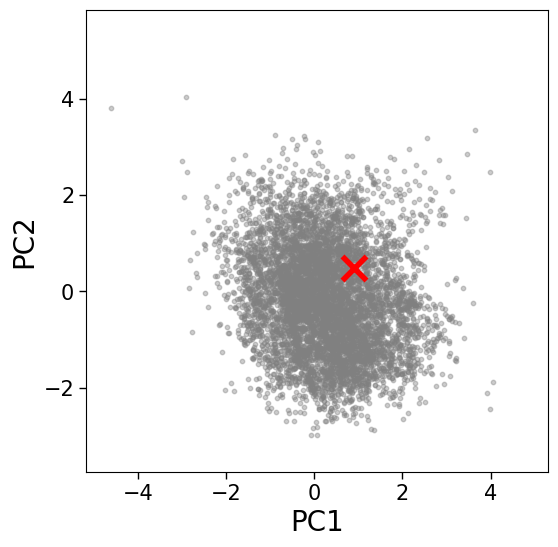

In [30]:
fig, ax = plt.subplots(figsize = (6, 6))

# pcaxy = {'x': list(), 'y': list()}
for d in date_list_train:
    if f'occ_{species}_{d}' in df_species:
        i_p = df_species[f'occ_{species}_{d}'] == 1
        ax.scatter(df_env_value[f'PC{x_pca:02d}_{d}'][i_p], df_env_value[f'PC{y_pca:02d}_{d}'][i_p], c = 'grey', alpha = 0.4, s = 10)
#         pcaxy['x'] = pcaxy['x'] + list(df_env_value[f'PC{x_pca:02d}_{d}'][i_p])
#         pcaxy['y'] = pcaxy['y'] + list(df_env_value[f'PC{y_pca:02d}_{d}'][i_p])

# # calculate the negative regression of every cell of 2d-niche space to the niche center
# # 计算每个单元格的宽度和高度
# cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
# cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]

# # 遍历每个单元格以计算中心点坐标
# coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
# for i in range(niche_rst_size):
#     for j in range(niche_rst_size):
#         coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  #center_x
#         coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2) # center_y
#         coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])  # value_deepsdm

# df_cor = pd.DataFrame(coordinates_values).query('value_deepsdm > 0').reset_index(drop = True)    
# df_cor_only = df_cor.loc[df_cor['value_deepsdm'] > 0, ['center_x', 'center_y']].reset_index(drop = True)

# # 計算加權的中心
# center_x = np.multiply(np.array(coordinates_values['center_x']), np.array(coordinates_values['value_deepsdm'])).sum() / np.array(coordinates_values['value_deepsdm']).sum()
# center_y = np.multiply(np.array(coordinates_values['center_y']), np.array(coordinates_values['value_deepsdm'])).sum() / np.array(coordinates_values['value_deepsdm']).sum()
# center = np.array([center_x, center_y])
# # 確保 x 和 y 軸等長，調整邊界讓其保持正方形
# xlims = [extent[0], extent[1]]
# ylims = [extent[2], extent[3]]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_box_aspect(1)  # 使用 set_box_aspect 來強制 x 和 y 軸等比例顯示，確保正方形


ax.scatter(center[0], center[1], c = 'red', s = 300, marker = 'x', linewidths = 4)
ax.set_ylabel('PC2', fontsize = 20)
ax.set_xlabel('PC1', fontsize = 20)
ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
ax.tick_params(axis='both', which='both', length=5, width=1)  # 調整長度和寬度

### 第二張圖：niche空間的機率圖

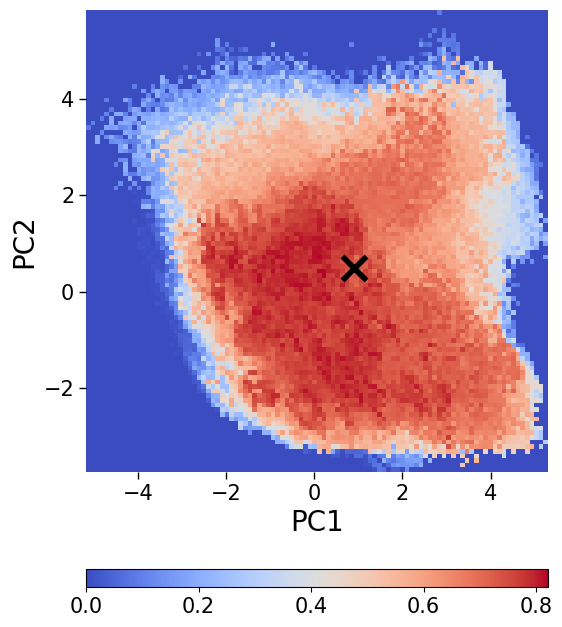

In [31]:
fig, ax = plt.subplots(figsize = (6, 6))
ax_imshow = ax.imshow(nichespace_deepsdm, cmap = 'coolwarm', extent = extent)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('PC2', fontsize = 20)
ax.set_xlabel('PC1', fontsize = 20)
ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
ax.tick_params(axis='both', which='both', length=5, width=1)  # 調整長度和寬度

ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])))  # 計算x和y的比例，並設置為等比例

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x0, 
                        ax_pos.y0 - ax_pos.height*0.25, 
                        ax_pos.width*1, 
                        ax_pos.height*0.04])


cbar = fig.colorbar(ax_imshow, ax = ax, orientation='horizontal', cax = cbar_ax)

# cbar.ax.tick_params(labelsize=20, which = 'both')
ax.scatter(center[0], center[1], c = 'black', s = 300, marker = 'x', linewidths=4)

cbar.ax.tick_params(labelsize=15, which='both')  # 調整刻度標籤字體大小

### 第三張圖：出現點位圖

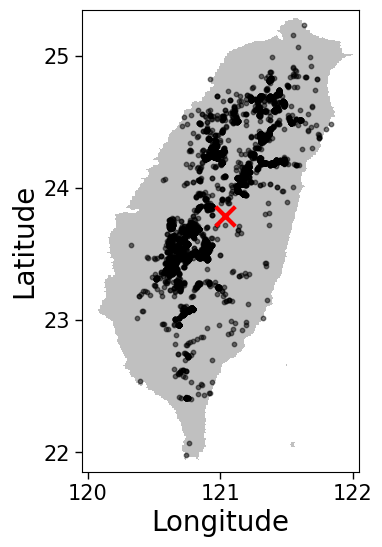

In [32]:
fig, ax = plt.subplots(figsize = (6, 6))

ax_imshow = ax.imshow(np.where(extent_binary == 1, extent_binary, np.nan), cmap = ListedColormap(['silver']), extent = extent_binary_extent)
lon_all, lat_all = rasterio.transform.xy(transform, y_all, x_all, offset='center')
ax.scatter(lon_all, lat_all, c = 'black', s = 10, alpha = 0.5)
ax.scatter(lon_center, lat_center, c = 'red', s = 200, marker = 'x', linewidths = 3)
ax.set_ylabel('Latitude', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 20)
ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
ax.tick_params(axis='both', which='both', length = 5, width = 1)  # 調整長度和寬度
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Y 軸只顯示整數

### 第四張圖：地理空間的機率圖

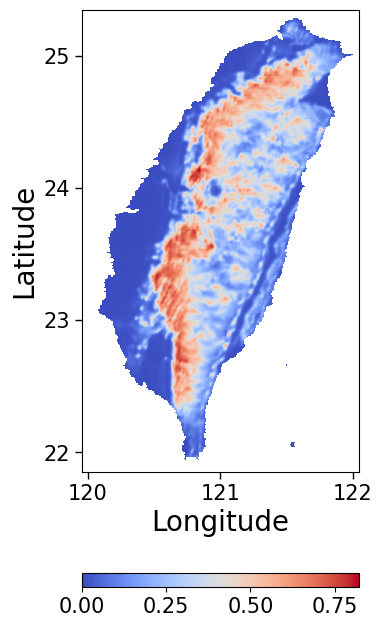

In [33]:
fig, ax = plt.subplots(figsize = (6, 6))

ax_imshow = ax.imshow(img_sum, cmap='coolwarm', extent = extent_binary_extent, vmin = 0)

ax.set_ylabel('Latitude', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 20)
ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
ax.tick_params(axis='both', which='both', length=5, width=1)  # 調整長度和寬度

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x0, 
                        ax_pos.y0 - ax_pos.height*0.25, 
                        ax_pos.width*1, 
                        ax_pos.height*0.03])
cbar = fig.colorbar(ax_imshow, ax=ax, orientation='horizontal', cax=cbar_ax)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Y 軸只顯示整數

# 設定 tick 的字體大小
cbar.ax.tick_params(labelsize=15, which='both')  # 調整刻度標籤字體大小

# cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # 設置刻度間隔為 1
plt.show()

### 第五張圖：niche空間中的center-periphery的散布圖

Text(0.8845000000000001, 0.8646, '$\\rho$=-0.79***')

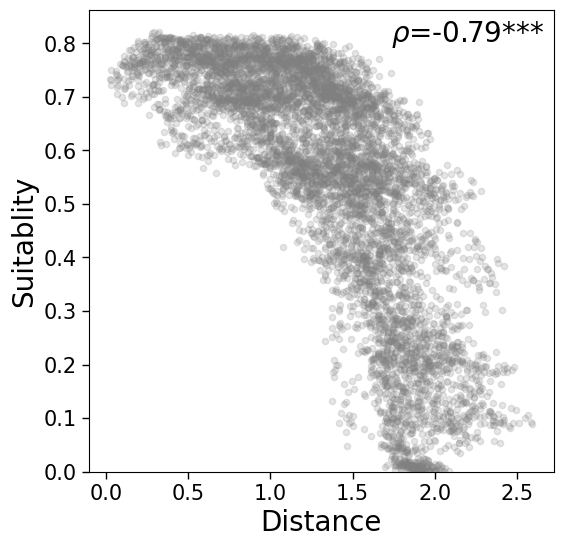

In [35]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(df_cor['distance_mah'][condition_deepsdm], df_cor['value_deepsdm'][condition_deepsdm], alpha = 0.2, color = 'grey', s = 20)

ax.tick_params(axis='both', which='both', length=5, width=1)  # 調整長度和寬度
ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
ax.yaxis.get_offset_text().set_size(15)  # 調整「x 10^n」的字體大小
ax.set_ylabel('Suitablity', fontsize = 20)
ax.set_xlabel('Distance', fontsize = 20)
ax.set_ylim(bottom=0)
ax_pos = ax.get_position()

fig.text(x = ax_pos.x1 - ax_pos.width * 0.02, 
         y = ax_pos.y1 - ax_pos.height * 0.02, 
         s = rf'$\rho$={rho_eco:.2f}{get_significance_stars(p_eco)}', 
         fontsize=20, ha = 'right', va = 'top')

### 第六張圖：biotop空間中的center-periphery的散布圖

Text(0.8845000000000001, 0.8646, '$\\rho$=-0.24***')

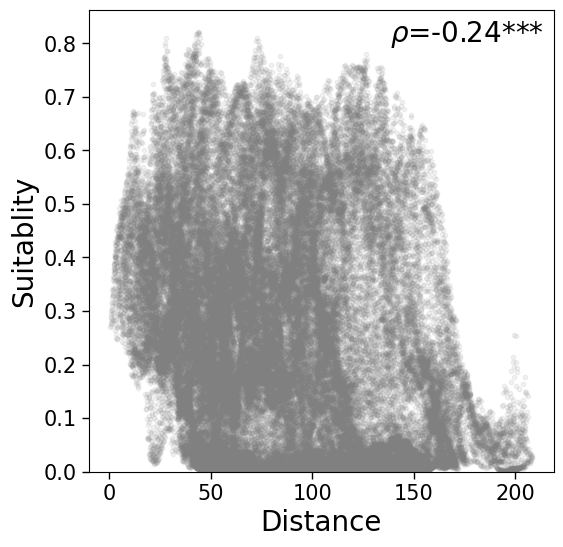

In [39]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(distances_all, cell_values_all, alpha = 0.1, color = 'grey', s = 10)

ax.tick_params(axis='both', which='both', length=5, width=1)  # 調整長度和寬度
ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
ax.yaxis.get_offset_text().set_size(15)  # 調整「x 10^n」的字體大小
ax.set_ylabel('Suitablity', fontsize = 20)
ax.set_xlabel('Distance', fontsize = 20)
ax.set_ylim(bottom=0)

ax_pos = ax.get_position()
fig.text(x = ax_pos.x1 - ax_pos.width * 0.02, 
         y = ax_pos.y1 - ax_pos.height * 0.02, 
         s = rf'$\rho$={rho_geo:.2f}{get_significance_stars(p_geo)}', 
         fontsize=20, 
         ha = 'right', 
         va = 'top')

In [40]:
len(cell_values_all)

79682

# 畫地理中心與棲位中心所算得的Spearman's rho

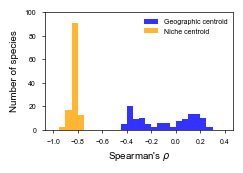

In [854]:
df_spearman = pd.read_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'spearman_info_basedonDeepSDMpred.csv'))

# 繪製兩個直方圖在同一張圖中，並設置不同的顏色和透明度
fig, ax = plt.subplots(figsize = mm2inch(60, 40), gridspec_kw = {'left': 0.15, 'right': 0.95, 'bottom': 0.2, 'top': 0.95})

# 設定固定 bin 寬度
bin_width = 0.05
bins = np.arange(-1, 0.4 + bin_width, bin_width)  # 建立範圍 -1 到 1，間隔為 0.1

# 第一個直方圖
ax.hist(df_spearman['rho'][df_spearman.center_type == 'Geographical_basedonDeepSDMpred'], bins=bins, label='Geographic centroid', color='blue', alpha = 0.8)

# 第二個直方圖 (niche deepsdm model)
ax.hist(df_spearman['rho'][df_spearman.center_type == 'Ecological_basedonDeepSDMpred'], bins=bins, label='Niche centroid', color='orange', alpha = 0.8)

# 添加圖例、標籤和標題
ax.legend(loc='upper right')  # 調整圖例字體大小
ax.set_xlabel(rf"Spearman's $\rho$")  # 調整x軸標籤字體大小
ax.set_ylabel('Number of species')  # 調整y軸標籤字體大小
ax.set_ylim(top = 100)
# 儲存
fig_path = os.path.join(plot_path_subplots, 'DeepSDM_rho_comparison_basedonDeepSDMpred_hist.pdf')
plt.savefig(fig_path, dpi = 500, transparent = True)

plt.show()

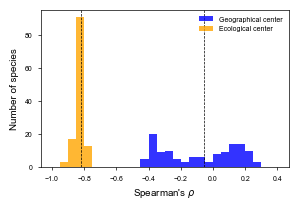

In [122]:
# 讀取資料
df_spearman = pd.read_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'spearman_info_basedonDeepSDMpred.csv'))

# 計算兩個分布的 median
median_geo = df_spearman['rho'][df_spearman.center_type == 'Geographical_basedonDeepSDMpred'].median()
median_ecol = df_spearman['rho'][df_spearman.center_type == 'Ecological_basedonDeepSDMpred'].median()

# 繪製圖形
fig, ax = plt.subplots(figsize=mm2inch(90, 50), gridspec_kw={'left': 0.25, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})

# 設定固定 bin 寬度
bin_width = 0.05
bins = np.arange(-1, 0.4 + bin_width, bin_width)

# 繪製第一個直方圖：Geographical center
ax.hist(df_spearman['rho'][df_spearman.center_type == 'Geographical_basedonDeepSDMpred'],
        bins=bins, label='Geographical center', color='blue', alpha=0.8)

# 繪製第二個直方圖：Ecological center
ax.hist(df_spearman['rho'][df_spearman.center_type == 'Ecological_basedonDeepSDMpred'],
        bins=bins, label='Ecological center', color='orange', alpha=0.8)

# 在圖中繪製 median 的虛線
ax.axvline(median_geo, color='black', linestyle='--', linewidth=0.5)
ax.axvline(median_ecol, color='black', linestyle='--', linewidth=0.5)

# 添加圖例、標籤
ax.legend(loc='upper right')
ax.set_xlabel(rf"Spearman's $\rho$")
ax.set_ylabel('Number of species')

# 儲存圖檔
fig_path = os.path.join(plot_path_subplots, 'DeepSDM_rho_comparison_basedonDeepSDMpred_hist.pdf')
plt.savefig(fig_path, dpi=500, transparent=True)
plt.show()


In [70]:
# 1. 分別取出兩組 Spearman's ρ 值
rho_geo = df_spearman.loc[df_spearman.center_type == 'Geographical_basedonDeepSDMpred', 'rho'].dropna()
rho_eco = df_spearman.loc[df_spearman.center_type == 'Ecological_basedonDeepSDMpred', 'rho'].dropna()

# ----------------------------
# 2. Kolmogorov–Smirnov (K-S) 雙樣本檢定
# ----------------------------
ks_stat, ks_pvalue = scipy.stats.ks_2samp(rho_geo, rho_eco)

print("=== Kolmogorov–Smirnov (K-S) test ===")
print(f"K-S statistic = {ks_stat:.4f}")
print(f"K-S p-value   = {ks_pvalue:.4e}")

# ----------------------------
# 3. Mann–Whitney U 檢定
# ----------------------------
# 如果你想檢驗的是雙尾(兩側)差異，請使用 alternative='two-sided'
# 如果你預期其中一組顯著較大或較小，可以改用 'greater' 或 'less'
mw_stat, mw_pvalue = scipy.stats.mannwhitneyu(rho_geo, rho_eco, alternative='two-sided')

print("=== Mann–Whitney U test ===")
print(f"U statistic   = {mw_stat:.4f}")
print(f"p-value       = {mw_pvalue:.4e}")

# ----------------------------
# 4. 補充：描述統計 (選擇性)
# ----------------------------
print("\n=== Descriptive statistics ===")
print("Geographical center (Spearman's rho):")
print(rho_geo.describe())
print("\nEcological center (Spearman's rho):")
print(rho_eco.describe())


=== Kolmogorov–Smirnov (K-S) test ===
K-S statistic = 1.0000
K-S p-value   = 4.3856e-74
=== Mann–Whitney U test ===
U statistic   = 15500.0000
p-value       = 2.4029e-42

=== Descriptive statistics ===
Geographical center (Spearman's rho):
count    125.000000
mean      -0.082397
std        0.229950
min       -0.410720
25%       -0.306920
50%       -0.057451
75%        0.133390
max        0.291999
Name: rho, dtype: float64

Ecological center (Spearman's rho):
count    124.000000
mean      -0.826219
std        0.027424
min       -0.918462
25%       -0.841102
50%       -0.819488
75%       -0.810922
max       -0.769711
Name: rho, dtype: float64


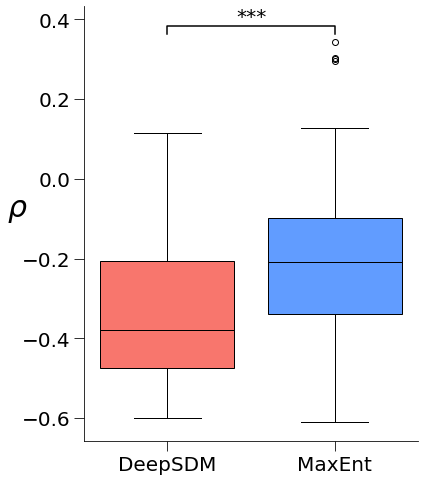

In [135]:
# 假设您已经加载了数据到 DataFrame df
# df = pd.read_csv(os.path.join(plot_path, 'spearman_info.csv'))
df = df_spearman.copy()
# 确保数据是按物种配对的
grouped_rho_values = df.pivot(index='species', columns='model', values='rho')
paired_rho_values = grouped_rho_values.dropna()  # 删除任何缺失值

# 进行配对 t 测试
t_stat, p_value = ttest_rel(paired_rho_values['deepsdm'], paired_rho_values['maxent'])

# 绘制箱形图
fig, ax = plt.subplots(1, 1, figsize = (6, 8))
bp = ax.boxplot([paired_rho_values.deepsdm, paired_rho_values.maxent], 
                showfliers=True, 
                labels = ['DeepSDM', 'MaxEnt'], 
                patch_artist = True, 
                widths = 0.8, 
                medianprops = dict(color = 'black'))
ax.set_ylabel(rf'$\rho$', size = 30, rotation = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', labelsize=20, length = 10)
colors = ['#F8766D', '#619CFF']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    
x1, x2 = 1, 2  # 箱子的位置，根据您的箱形图的实际位置调整
y, h, col = max(max(paired_rho_values.deepsdm), max(paired_rho_values.maxent)) + 0.02, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
if p_value < 0.005:
    plt.text((x1 + x2) * .5, y + h, "***", ha='center', va='bottom', color=col, fontsize = 20)
    
path_out = os.path.join(plot_path, f'correlation_comparison_boxplot.png')
# plt.savefig(path_out, dpi = 50, transparent = False, facecolor='white',  bbox_inches='tight')

# 測試用，勿刪

In [35]:
species_to_print = ['Yuhina_brunneiceps', 'Psilopogon_nuchalis', 'Locustella_alishanensis', 'Gallinula_chloropus']
species_to_print = ['Gallinula_chloropus']

In [43]:
cluster_label = [3, 3, 3, 2, 1, 3, 2, 3, 3, 2, 3, 3, 3, 1, 2, 1, 2, 2, 3, 3, 2, 2,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3,
       2, 3, 3, 2, 1, 3, 3, 3, 3, 2, 3, 2, 3, 1, 2, 2, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 2, 3, 1, 1, 3, 3, 3, 2, 2, 2, 3,
       1, 3, 2, 3, 1, 1, 3, 1, 2, 2, 2, 1, 2, 3, 3, 3, 2, 1, 1, 1, 3, 1,
       1, 1, 2, 3, 1, 1, 3, 2, 3, 3, 3, 3, 3, 1, 2]

## 二次回歸

In [74]:
ecological_fit_params = {}   # 格式：{ species: [a, b, c] }
geographical_fit_params = {} # 格式：{ species: [a, b, c] }


# 假設 species_to_print, date_list_predict, extent_binary, transform, extent_info, 
# sp_inf, deepsdm_h5_path, plot_path_df, plot_path_nichespace_h5, height, width, crs, 
# df_grid, etc. 已在程式中定義

# 依序處理每一個物種
for species in species_list_predict:
    print(f"Processing species: {species}\r", end = '')
    
    # -------------------------
    # 1. 讀取所有訓練時間點的影像並計算重心（地理中心）
    x_all = []
    y_all = []
    for time in date_list_predict:
        img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
        # 找出所有值為1的像素位置
        y_coords = np.where(img == 1)[0]
        x_coords = np.where(img == 1)[1]
        x_all.extend(x_coords)
        y_all.extend(y_coords)
    # 平均計算像素重心（像素座標）
    x_center_real = np.mean(x_all)
    y_center_real = np.mean(y_all)
    # 轉換為地理座標
    lon_center_real, lat_center_real = rasterio.transform.xy(transform, y_center_real, x_center_real, offset='center')
    
    # -------------------------
    # 2. 讀取 h5 檔並累計所有時間點的結果（地理資料）
    img_sum = None
    with h5py.File(deepsdm_h5_path.replace('[SPECIES]', species), 'r') as hf:
        for date in date_list_predict:
            if img_sum is None:
                img_sum = hf[date][:].copy()
            else:
                img_sum = np.maximum(img_sum, hf[date][:].copy())
    
    # -------------------------
    # 3. 使用 rasterio 批量處理將所有像素索引轉換為經緯度
    x_indices = np.where(extent_binary == 1)[1]
    y_indices = np.where(extent_binary == 1)[0]
    lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
    lons, lats = zip(*lon_lat_pairs)
    lons = np.array(lons)
    lats = np.array(lats)
    
    # 計算加權後的地理中心（依據 img_sum 的值加權）
    valid_mask = ~np.isnan(img_sum)
    total = img_sum[valid_mask].sum()
    y_weighted = (np.where(valid_mask)[0] * img_sum[valid_mask]).sum() / total
    x_weighted = (np.where(valid_mask)[1] * img_sum[valid_mask]).sum() / total
    lon_center, lat_center = rasterio.transform.xy(transform, y_weighted, x_weighted, offset='center')
    
    # 計算每個像素與地理中心之間的距離
    distances_all = haversine(lats, lons, lat_center, lon_center)
    # 將 img_sum 平展後取非 NaN 值
    cell_values_all = img_sum[valid_mask].flatten()
    
    # -------------------------
    # 4. 計算生態中心（niche space）的資料
    # 先根據 PC 軸資訊建立 extent
    x_pca = 1
    y_pca = 2
    extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
              extent_info[f'PC{x_pca:02d}_extent_max'], 
              extent_info[f'PC{y_pca:02d}_extent_min'], 
              extent_info[f'PC{y_pca:02d}_extent_max']]
    
    # 透過預先計算的 nichespace_deepsdm 產生網格坐標
    with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
        nichespace_deepsdm = hf['deepsdm_all_season_max'][:]
    
    niche_rst_size = 100
    cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
    cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]
    coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)
            coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2)
            coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])
    df_cor = pd.DataFrame(coordinates_values)
    # 僅保留 value_deepsdm > 0 的資料
    df_cor = df_cor.query('value_deepsdm > 0').reset_index(drop=True)
    
    # 為計算 Mahalanobis 距離，我們先計算生態空間中非零值的中心與協方差矩陣
    df_cor_only = df_cor[['center_x', 'center_y']]
    cov_matrix = np.cov(df_cor_only, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    # 加權計算生態空間中心（依據 value_deepsdm 的值）
    center_x = np.average(df_cor['center_x'], weights=df_cor['value_deepsdm'])
    center_y = np.average(df_cor['center_y'], weights=df_cor['value_deepsdm'])
    center = np.array([center_x, center_y])
    # 計算 Mahalanobis 距離，並存入新欄位
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)
    
    # 定義條件（實際上 df_cor 的 value_deepsdm 已皆大於 0）
    condition_deepsdm = df_cor['value_deepsdm'] > 0
    
    # -------------------------
    # 5. 生態中心的二次多項式擬合（Fig 5）
    x_eco = df_cor['distance_mah'][condition_deepsdm]
    y_eco = df_cor['value_deepsdm'][condition_deepsdm]
    coefficients_eco = np.polyfit(x_eco, y_eco, 2)  # 得到 [a, b, c]，代表 a*x^2 + b*x + c
    ecological_fit_params[species] = np.append(coefficients_eco, [np.min(x_eco), np.max(x_eco)])  # 儲存參數
    
    # -------------------------
    # 6. 地理中心的二次多項式擬合（Fig 6）
    x_geo = distances_all
    y_geo = cell_values_all
    coefficients_geo = np.polyfit(x_geo, y_geo, 2)
    geographical_fit_params[species] = np.append(coefficients_geo, [np.min(x_geo), np.max(x_geo)])  # 儲存參數
    
# -------------------------


# 如果需要，也可以將參數儲存成檔案，例如：
eco_params_df = pd.DataFrame.from_dict(ecological_fit_params, orient='index', columns=['a', 'b', 'c', 'min_distance', 'max_distance'])
geo_params_df = pd.DataFrame.from_dict(geographical_fit_params, orient='index', columns=['a', 'b', 'c', 'min_distance', 'max_distance'])
eco_params_df.to_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "ecological_fit_params.csv"))
geo_params_df.to_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "geographical_fit_params.csv"))


In [94]:
color_list = ['#4daf4a', '#984ea3', '#ff7f00']

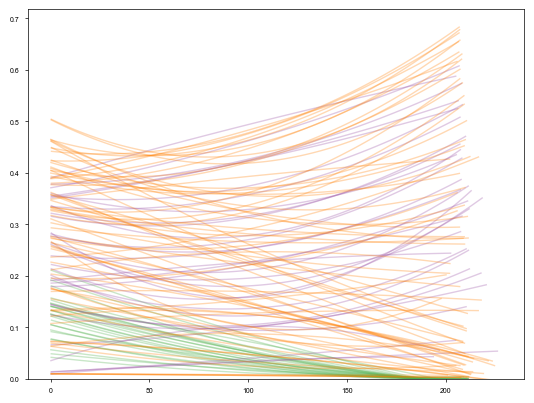

In [107]:
fig, ax = plt.subplots()
for cluster in [1, 2, 3]: 
    for i, data in geo_params_df.loc[np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()].iterrows():
        p = np.poly1d([data.a, data.b, data.c])
        x_sorted = np.linspace(data.min_distance, data.max_distance, 100)
        y_sorted = p(x_sorted)
        ax.plot(x_sorted, y_sorted, color=color_list[cluster-1], linewidth=1, alpha = 0.3)
ax.set_ylim(bottom=0)
plt.show()

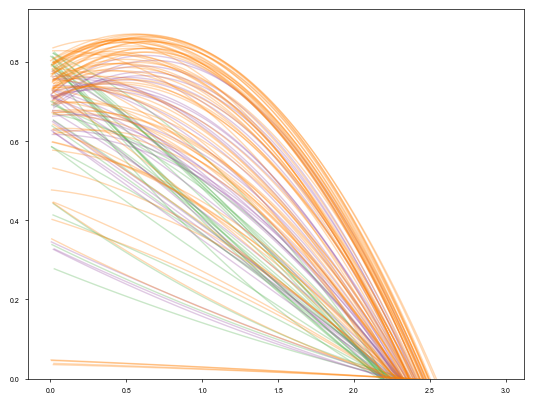

In [106]:
fig, ax = plt.subplots()
for cluster in [1, 2, 3]: 
    for i, data in eco_params_df.loc[np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()].iterrows():
        p = np.poly1d([data.a, data.b, data.c])
        x_sorted = np.linspace(data.min_distance, data.max_distance, 100)
        y_sorted = p(x_sorted)
        ax.plot(x_sorted, y_sorted, color=color_list[cluster-1], linewidth=1, alpha = 0.3)
ax.set_ylim(bottom=0)
plt.show()

## 線性回歸

In [110]:
ecological_fit_params = {}   # 格式：{ species: [a, b, min_distance, max_distance] }
geographical_fit_params = {} # 格式：{ species: [a, b, min_distance, max_distance] }

# 假設 species_to_print, date_list_predict, extent_binary, transform, extent_info, 
# sp_inf, deepsdm_h5_path, plot_path_df, plot_path_nichespace_h5, height, width, crs, 
# df_grid, etc. 已在程式中定義

# 依序處理每一個物種
for species in species_list_predict:
    print(f"Processing species: {species}\r", end = '')
    
    # -------------------------
    # 1. 讀取所有訓練時間點的影像並計算重心（地理中心）
    x_all = []
    y_all = []
    for time in date_list_predict:
        img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
        # 找出所有值為1的像素位置
        y_coords = np.where(img == 1)[0]
        x_coords = np.where(img == 1)[1]
        x_all.extend(x_coords)
        y_all.extend(y_coords)
    # 平均計算像素重心（像素座標）
    x_center_real = np.mean(x_all)
    y_center_real = np.mean(y_all)
    # 轉換為地理座標
    lon_center_real, lat_center_real = rasterio.transform.xy(transform, y_center_real, x_center_real, offset='center')
    
    # -------------------------
    # 2. 讀取 h5 檔並累計所有時間點的結果（地理資料）
    img_sum = None
    with h5py.File(deepsdm_h5_path.replace('[SPECIES]', species), 'r') as hf:
        for date in date_list_predict:
            if img_sum is None:
                img_sum = hf[date][:].copy()
            else:
                img_sum = np.maximum(img_sum, hf[date][:].copy())
    
    # -------------------------
    # 3. 使用 rasterio 批量處理將所有像素索引轉換為經緯度
    x_indices = np.where(extent_binary == 1)[1]
    y_indices = np.where(extent_binary == 1)[0]
    lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
    lons, lats = zip(*lon_lat_pairs)
    lons = np.array(lons)
    lats = np.array(lats)
    
    # 計算加權後的地理中心（依據 img_sum 的值加權）
    valid_mask = ~np.isnan(img_sum)
    total = img_sum[valid_mask].sum()
    y_weighted = (np.where(valid_mask)[0] * img_sum[valid_mask]).sum() / total
    x_weighted = (np.where(valid_mask)[1] * img_sum[valid_mask]).sum() / total
    lon_center, lat_center = rasterio.transform.xy(transform, y_weighted, x_weighted, offset='center')
    
    # 計算每個像素與地理中心之間的距離
    distances_all = haversine(lats, lons, lat_center, lon_center)
    # 將 img_sum 平展後取非 NaN 值
    cell_values_all = img_sum[valid_mask].flatten()
    
    # -------------------------
    # 4. 計算生態中心（niche space）的資料
    # 先根據 PC 軸資訊建立 extent
    x_pca = 1
    y_pca = 2
    extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
              extent_info[f'PC{x_pca:02d}_extent_max'], 
              extent_info[f'PC{y_pca:02d}_extent_min'], 
              extent_info[f'PC{y_pca:02d}_extent_max']]
    
    # 透過預先計算的 nichespace_deepsdm 產生網格坐標
    with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
        nichespace_deepsdm = hf['deepsdm_all_season_max'][:]
    
    niche_rst_size = 100
    cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
    cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]
    coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)
            coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2)
            coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])
    df_cor = pd.DataFrame(coordinates_values)
    # 僅保留 value_deepsdm > 0 的資料
    df_cor = df_cor.query('value_deepsdm > 0').reset_index(drop=True)
    
    # 為計算 Mahalanobis 距離，我們先計算生態空間中非零值的中心與協方差矩陣
    df_cor_only = df_cor[['center_x', 'center_y']]
    cov_matrix = np.cov(df_cor_only, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    # 加權計算生態空間中心（依據 value_deepsdm 的值）
    center_x = np.average(df_cor['center_x'], weights=df_cor['value_deepsdm'])
    center_y = np.average(df_cor['center_y'], weights=df_cor['value_deepsdm'])
    center = np.array([center_x, center_y])
    # 計算 Mahalanobis 距離，並存入新欄位
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)
    
    # 定義條件（實際上 df_cor 的 value_deepsdm 已皆大於 0）
    condition_deepsdm = df_cor['value_deepsdm'] > 0
    
    # -------------------------
    # 5. 生態中心的線性回歸擬合（原 Fig 5 改為線性）
    x_eco = df_cor['distance_mah'][condition_deepsdm]
    y_eco = df_cor['value_deepsdm'][condition_deepsdm]
    coefficients_eco = np.polyfit(x_eco, y_eco, 1)  # 得到 [a, b]，代表 a*x + b
    ecological_fit_params[species] = np.append(coefficients_eco, [np.min(x_eco), np.max(x_eco)])  # 儲存參數
    
    # -------------------------
    # 6. 地理中心的線性回歸擬合（原 Fig 6 改為線性）
    x_geo = distances_all
    y_geo = cell_values_all
    coefficients_geo = np.polyfit(x_geo, y_geo, 1)  # 得到 [a, b]
    geographical_fit_params[species] = np.append(coefficients_geo, [np.min(x_geo), np.max(x_geo)])  # 儲存參數

# -------------------------

# 將參數儲存成新的檔案（線性回歸）
eco_params_df = pd.DataFrame.from_dict(ecological_fit_params, orient='index', columns=['a', 'b', 'min_distance', 'max_distance'])
geo_params_df = pd.DataFrame.from_dict(geographical_fit_params, orient='index', columns=['a', 'b', 'min_distance', 'max_distance'])
eco_params_df.to_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "ecological_linear_fit_params.csv"))
geo_params_df.to_csv(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "geographical_linear_fit_params.csv"))


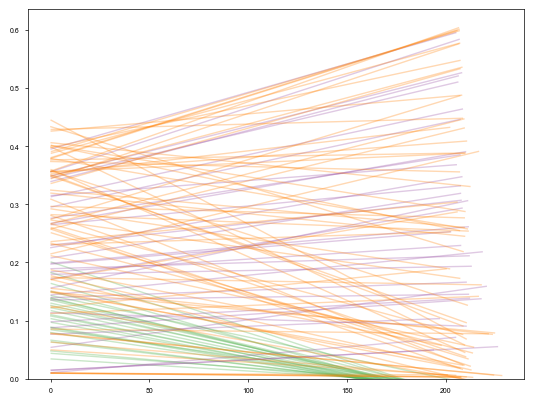

In [111]:
fig, ax = plt.subplots()
for cluster in [1, 2, 3]: 
    for i, data in geo_params_df.loc[np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()].iterrows():
        p = np.poly1d([data.a, data.b])
        x_sorted = np.linspace(data.min_distance, data.max_distance, 100)
        y_sorted = p(x_sorted)
        ax.plot(x_sorted, y_sorted, color=color_list[cluster-1], linewidth=1, alpha = 0.3)
ax.set_ylim(bottom=0)
plt.show()

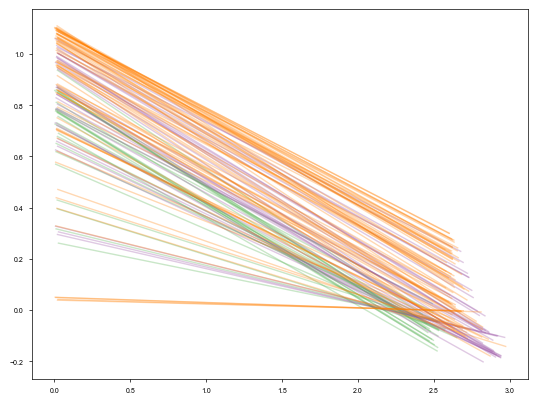

In [115]:
fig, ax = plt.subplots()
for cluster in [1, 2, 3]: 
    for i, data in eco_params_df.loc[np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()].iterrows():
        p = np.poly1d([data.a, data.b])
        x_sorted = np.linspace(data.min_distance, data.max_distance, 100)
        y_sorted = p(x_sorted)
        ax.plot(x_sorted, y_sorted, color=color_list[cluster-1], linewidth=1, alpha = 0.3)
ax.set_ylim()
plt.show()

## Beta regression

In [269]:
# -*- coding: utf-8 -*-

u"""
Beta regression for modeling rates and proportions.
References
----------
Grün, Bettina, Ioannis Kosmidis, and Achim Zeileis. Extended beta regression
in R: Shaken, stirred, mixed, and partitioned. No. 2011-22. Working Papers in
Economics and Statistics, 2011.
Smithson, Michael, and Jay Verkuilen. "A better lemon squeezer?
Maximum-likelihood regression with beta-distributed dependent variables."
Psychological methods 11.1 (2006): 54.
"""
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy.special import gammaln as lgamma

from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.genmod.families import Binomial

# this is only need while #2024 is open.
class Logit(sm.families.links.Logit):

    """Logit tranform that won't overflow with large numbers."""

    def inverse(self, z):
        return 1 / (1. + np.exp(-z))

_init_example = """
    Beta regression with default of logit-link for exog and log-link
    for precision.
    >>> mod = Beta(endog, exog)
    >>> rslt = mod.fit()
    >>> print rslt.summary()
    We can also specify a formula and a specific structure and use the
    identity-link for phi.
    >>> from sm.families.links import identity
    >>> Z = patsy.dmatrix('~ temp', dat, return_type='dataframe')
    >>> mod = Beta.from_formula('iyield ~ C(batch, Treatment(10)) + temp',
    ...                         dat, Z=Z, link_phi=identity())
    In the case of proportion-data, we may think that the precision depends on
    the number of measurements. E.g for sequence data, on the number of
    sequence reads covering a site:
    >>> Z = patsy.dmatrix('~ coverage', df)
    >>> mod = Beta.from_formula('methylation ~ disease + age + gender + coverage', df, Z)
    >>> rslt = mod.fit()
"""

class Beta(GenericLikelihoodModel):

    """Beta Regression.
    This implementation uses `phi` as a precision parameter equal to
    `a + b` from the Beta parameters.
    """

    def __init__(self, endog, exog, Z=None, link=Logit(),
            link_phi=sm.families.links.Log(), **kwds):
        """
        Parameters
        ----------
        endog : array-like
            1d array of endogenous values (i.e. responses, outcomes,
            dependent variables, or 'Y' values).
        exog : array-like
            2d array of exogeneous values (i.e. covariates, predictors,
            independent variables, regressors, or 'X' values). A nobs x k
            array where `nobs` is the number of observations and `k` is
            the number of regressors. An intercept is not included by
            default and should be added by the user. See
            `statsmodels.tools.add_constant`.
        Z : array-like
            2d array of variables for the precision phi.
        link : link
            Any link in sm.families.links for `exog`
        link_phi : link
            Any link in sm.families.links for `Z`
        Examples
        --------
        {example}
        See Also
        --------
        :ref:`links`
        """.format(example=_init_example)
        assert np.all((0 < endog) & (endog < 1))
        if Z is None:
            extra_names = ['phi']
            Z = np.ones((len(endog), 1), dtype='f')
        else:
            extra_names = ['precision-%s' % zc for zc in \
                        (Z.columns if hasattr(Z, 'columns') else range(1, Z.shape[1] + 1))]
        kwds['extra_params_names'] = extra_names

        super(Beta, self).__init__(endog, exog, **kwds)
        self.link = link
        self.link_phi = link_phi
        
        self.Z = Z
        assert len(self.Z) == len(self.endog)

    def nloglikeobs(self, params):
        """
        Negative log-likelihood.
        Parameters
        ----------
        params : np.ndarray
            Parameter estimates
        """
        return -self._ll_br(self.endog, self.exog, self.Z, params)

    def fit(self, start_params=None, maxiter=100000, maxfun=5000, disp=False,
            method='bfgs', **kwds):
        """
        Fit the model.
        Parameters
        ----------
        start_params : array-like
            A vector of starting values for the regression
            coefficients.  If None, a default is chosen.
        maxiter : integer
            The maximum number of iterations
        disp : bool
            Show convergence stats.
        method : str
            The optimization method to use.
        """

        if start_params is None:
            start_params = sm.GLM(self.endog, self.exog, family=Binomial()
                                 ).fit(disp=False).params
            start_params = np.append(start_params, [0.5] * self.Z.shape[1])

        return super(Beta, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        method=method, disp=disp, **kwds)

    def _ll_br(self, y, X, Z, params):
        nz = self.Z.shape[1]

        Xparams = params[:-nz]
        Zparams = params[-nz:]

        mu = self.link.inverse(np.dot(X, Xparams))
        phi = self.link_phi.inverse(np.dot(Z, Zparams))
        # TODO: derive a and b and constrain to > 0?

        if np.any(phi <= np.finfo(float).eps): return np.array(-np.inf)

        ll = lgamma(phi) - lgamma(mu * phi) - lgamma((1 - mu) * phi) \
                + (mu * phi - 1) * np.log(y) + (((1 - mu) * phi) - 1) \
                * np.log(1 - y)

        return ll

# if __name__ == "__main__":

#     import patsy
#     dat = pd.read_table('gasoline.txt')
#     Z = patsy.dmatrix('~ temp', dat, return_type='dataframe')
#     # using other precison params with
#     m = Beta.from_formula('iyield ~ C(batch, Treatment(10)) + temp', dat,
#             Z=Z, link_phi=sm.families.links.identity())
#     print(m.fit().summary())

#     fex = pd.read_csv('foodexpenditure.csv')
#     m = Beta.from_formula(' I(food/income) ~ income + persons', fex)
#     print(m.fit().summary())
#     #print GLM.from_formula('iyield ~ C(batch) + temp', dat, family=Binomial()).fit().summary()

#     dev = pd.read_csv('methylation-test.csv')
#     Z = patsy.dmatrix('~ age', dev, return_type='dataframe')
#     m = Beta.from_formula('methylation ~ gender + CpG', dev,
#             Z=Z,
#             link_phi=sm.families.links.identity())
#     print(m.fit().summary())

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -


                                 Beta Results                                 
Dep. Variable:                 iyield   Log-Likelihood:                 79.103
Model:                           Beta   AIC:                            -132.2
Method:            Maximum Likelihood   BIC:                            -113.2
Date:                Wed, 12 Mar 2025                                         
Time:                        15:44:12                                         
No. Observations:                  32                                         
Df Residuals:                      19                                         
Df Model:                          10                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -6.1302      0.302    -20.292      0.000      -6.722      -5.53

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [748]:
import os
import cv2
import numpy as np
import pandas as pd
import h5py
import rasterio
from rasterio.transform import xy
from scipy.spatial import distance
import statsmodels.api as sm
import statsmodels.formula.api as smf


# 物種參數字典初始化
ecological_fit_info = {}   # 格式：{ species: [slope, intercept, min_distance, max_distance] }
geographical_fit_info = {} # 格式：{ species: [slope, intercept, min_distance, max_distance] }

epsilon = 1e-8

# 依序處理每一個物種
for species in species_list_predict:
    print(f"Processing species: {species}\r", end = '')
    
    # -------------------------
    # 1. 讀取所有訓練時間點的影像並計算重心（地理中心）
    x_all = []
    y_all = []
    for time in date_list_predict:
        img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
        # 找出所有值為 1 的像素位置
        y_coords = np.where(img == 1)[0]
        x_coords = np.where(img == 1)[1]
        x_all.extend(x_coords)
        y_all.extend(y_coords)
    # 平均計算像素重心（像素座標）
    x_center_real = np.mean(x_all)
    y_center_real = np.mean(y_all)
    # 轉換為地理座標
    lon_center_real, lat_center_real = rasterio.transform.xy(transform, y_center_real, x_center_real, offset='center')
    
    # -------------------------
    # 2. 讀取 h5 檔並累計所有時間點的結果（地理資料）
    img_sum = None
    with h5py.File(deepsdm_h5_path.replace('[SPECIES]', species), 'r') as hf:
        for date in date_list_predict:
            if img_sum is None:
                img_sum = hf[date][:].copy()
            else:
                img_sum = np.maximum(img_sum, hf[date][:].copy())
    
    # -------------------------
    # 3. 使用 rasterio 批量處理將所有像素索引轉換為經緯度
    x_indices = np.where(extent_binary == 1)[1]
    y_indices = np.where(extent_binary == 1)[0]
    lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
    lons, lats = zip(*lon_lat_pairs)
    lons = np.array(lons)
    lats = np.array(lats)
    
    # 計算加權後的地理中心（依據 img_sum 的值加權）
    valid_mask = ~np.isnan(img_sum)
    total = img_sum[valid_mask].sum()
    y_weighted = (np.where(valid_mask)[0] * img_sum[valid_mask]).sum() / total
    x_weighted = (np.where(valid_mask)[1] * img_sum[valid_mask]).sum() / total
    lon_center, lat_center = rasterio.transform.xy(transform, y_weighted, x_weighted, offset='center')
    
    # 計算每個像素與地理中心之間的距離
    distances_all = haversine(lats, lons, lat_center, lon_center)
    # 將 img_sum 平展後取非 NaN 值
    cell_values_all = img_sum[valid_mask].flatten()
    
    # -------------------------
    # 4. 計算生態中心（niche space）的資料
    # 先根據 PC 軸資訊建立 extent
    x_pca = 1
    y_pca = 2
    extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
              extent_info[f'PC{x_pca:02d}_extent_max'], 
              extent_info[f'PC{y_pca:02d}_extent_min'], 
              extent_info[f'PC{y_pca:02d}_extent_max']]
    
    # 透過預先計算的 nichespace_deepsdm 產生網格坐標
    with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
        nichespace_deepsdm = hf['deepsdm_all_season_max'][:]
    
    niche_rst_size = 100
    cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
    cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]
    coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)
            coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2)
            coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])
    df_cor = pd.DataFrame(coordinates_values)
    # 僅保留 value_deepsdm > 0 的資料
    df_cor = df_cor.query('value_deepsdm > 0').reset_index(drop=True)
    
    # 為計算 Mahalanobis 距離，我們先計算生態空間中非零值的中心與協方差矩陣
    df_cor_only = df_cor[['center_x', 'center_y']]
    cov_matrix = np.cov(df_cor_only, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    # 加權計算生態空間中心（依據 value_deepsdm 的值）
    center_x = np.average(df_cor['center_x'], weights=df_cor['value_deepsdm'])
    center_y = np.average(df_cor['center_y'], weights=df_cor['value_deepsdm'])
    center = np.array([center_x, center_y])
    # 計算 Mahalanobis 距離，並存入新欄位
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)
    
    # 定義條件（實際上 df_cor 的 value_deepsdm 已皆大於 0）
    condition_deepsdm = df_cor['value_deepsdm'] > 0
    
    # -------------------------
    # **生態中心的 Beta 回歸**
    # 第 5 步：Beta regression (生態中心)
    x_eco = df_cor['distance_mah'].values
    y_eco = df_cor['value_deepsdm'].values

    # 正規化到 (0,1) 避免 0、1
    y_eco_normalize = (y_eco - np.min(y_eco)) / (np.max(y_eco) - np.min(y_eco)) \
                      * (1 - 2 * epsilon) + epsilon

    X_eco = sm.add_constant(x_eco)  # shape=(n,2)，第一欄截距
    model_eco = Beta(endog=y_eco_normalize,
                     exog=X_eco,
                     Z=None,                 # phi 沒有額外解釋變數
                     link=Logit(),           # \mu 的連結 (logit)
                     link_phi=sm.families.links.Log())  # phi 的連結 (log)
    result_eco = model_eco.fit(disp=False)

    # 假設 Z=None → 參數通常有 3 個: [intercept_mu, slope_mu, intercept_phi]
    # （如果 Beta 類別實作相同於先前提供的範例）
    params_eco = result_eco.params
    intercept_mu_eco = params_eco[0]   # \(\beta_0\)
    slope_mu_eco     = params_eco[1]   # \(\beta_1\)
    intercept_phi_eco = params_eco[2]  # phi 參數 (常數)

    # 另外紀錄 x, y 的 min/max，之後重畫時才知道如何逆規模化
    x_min_eco = float(np.min(x_eco))
    x_max_eco = float(np.max(x_eco))
    y_min_eco = float(np.min(y_eco))   # 原始 y 的 min
    y_max_eco = float(np.max(y_eco))   # 原始 y 的 max

    # 將本物種的參數存入 dictionary
    ecological_fit_info[species] = {
        "mu_link":    "logit",
        "phi_link":   "log",
        "params_mu":  [float(intercept_mu_eco), float(slope_mu_eco)],
        "params_phi": [float(intercept_phi_eco)],
        "x_min":      x_min_eco,
        "x_max":      x_max_eco,
        "y_min":      y_min_eco,
        "y_max":      y_max_eco,
        "epsilon":    epsilon  # 將用於日後反向還原
    }

    # -------------------------
    # 第 6 步：Beta regression (地理中心)
    x_geo = distances_all
    y_geo = cell_values_all

    y_geo_normalize = (y_geo - np.min(y_geo)) / (np.max(y_geo) - np.min(y_geo)) \
                      * (1 - 2 * epsilon) + epsilon

    X_geo = sm.add_constant(x_geo)
    model_geo = Beta(endog=y_geo_normalize,
                     exog=X_geo,
                     Z=None,
                     link=Logit(),
                     link_phi=sm.families.links.Log())
    result_geo = model_geo.fit(disp=False)

    params_geo = result_geo.params
    intercept_mu_geo = params_geo[0]
    slope_mu_geo     = params_geo[1]
    intercept_phi_geo = params_geo[2]

    x_min_geo = float(np.min(x_geo))
    x_max_geo = float(np.max(x_geo))
    y_min_geo = float(np.min(y_geo))
    y_max_geo = float(np.max(y_geo))

    geographical_fit_info[species] = {
        "mu_link":    "logit",
        "phi_link":   "log",
        "params_mu":  [float(intercept_mu_geo), float(slope_mu_geo)],
        "params_phi": [float(intercept_phi_geo)],
        "x_min":      x_min_geo,
        "x_max":      x_max_geo,
        "y_min":      y_min_geo,
        "y_max":      y_max_geo,
        "epsilon":    epsilon
    }

    # 如需示範，就處理完一個 species 後 break
#     break

# -------------------------
# 把結果分別存到 2 個 JSON 檔：
with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "ecological_beta_params.json"), "w") as f:
    json.dump(ecological_fit_info, f, indent=4)

with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "geographical_beta_params.json"), "w") as f:
    json.dump(geographical_fit_info, f, indent=4)

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/tmp/ipykernel_1629260/3758204568.py:29: RuntimeWarning: overflow encountered in exp
  return 1 / (1. + np.exp(-z))
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/tmp/ipykernel_1629260/3758204568.py:150: RuntimeWarning: invalid value encountered in multiply
  ll = lgamma(phi) - lgamma(mu * phi) - lgamma((1 - mu) * phi) \
/tmp/ipykernel_1629260/3758204568.py:150: RuntimeWarning: invalid value encountered in subtract
  ll = lgamma(phi) - lgamma(mu * phi) - lgamma((1 - mu) * phi) \
/tmp/ipykernel_1629260/3758204568.

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -


KeyboardInterrupt: 

# 以cluster內的所有點來算beta regression

In [718]:
# 物種參數字典初始化
ecological_fit_info = {}   # 格式：{ species: [slope, intercept, min_distance, max_distance] }
geographical_fit_info = {} # 格式：{ species: [slope, intercept, min_distance, max_distance] }

epsilon = 1e-8

for cluster in range(1, 4):
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster]
    # 依序處理每一個物種
    df_cluster = []
    distances_all_cluster = []
    cell_values_all_cluster = []
    for species in species_list_cluster:
        print(f"Processing species: {species}\r", end = '')

        # -------------------------
        # 1. 讀取所有訓練時間點的影像並計算重心（地理中心）
        x_all = []
        y_all = []
        for time in date_list_predict:
            img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
            # 找出所有值為 1 的像素位置
            y_coords = np.where(img == 1)[0]
            x_coords = np.where(img == 1)[1]
            x_all.extend(x_coords)
            y_all.extend(y_coords)
        # 平均計算像素重心（像素座標）
        x_center_real = np.mean(x_all)
        y_center_real = np.mean(y_all)
        # 轉換為地理座標
        lon_center_real, lat_center_real = rasterio.transform.xy(transform, y_center_real, x_center_real, offset='center')

        # -------------------------
        # 2. 讀取 h5 檔並累計所有時間點的結果（地理資料）
        img_sum = None
        with h5py.File(deepsdm_h5_path.replace('[SPECIES]', species), 'r') as hf:
            for date in date_list_predict:
                if img_sum is None:
                    img_sum = hf[date][:].copy()
                else:
                    img_sum = np.maximum(img_sum, hf[date][:].copy())

        # -------------------------
        # 3. 使用 rasterio 批量處理將所有像素索引轉換為經緯度
        x_indices = np.where(extent_binary == 1)[1]
        y_indices = np.where(extent_binary == 1)[0]
        lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
        lons, lats = zip(*lon_lat_pairs)
        lons = np.array(lons)
        lats = np.array(lats)

        # 計算加權後的地理中心（依據 img_sum 的值加權）
        valid_mask = ~np.isnan(img_sum)
        total = img_sum[valid_mask].sum()
        y_weighted = (np.where(valid_mask)[0] * img_sum[valid_mask]).sum() / total
        x_weighted = (np.where(valid_mask)[1] * img_sum[valid_mask]).sum() / total
        lon_center, lat_center = rasterio.transform.xy(transform, y_weighted, x_weighted, offset='center')

        # 計算每個像素與地理中心之間的距離
        distances_all = haversine(lats, lons, lat_center, lon_center)
        # 將 img_sum 平展後取非 NaN 值
        cell_values_all = img_sum[valid_mask].flatten()
        
        distances_all_cluster.append(distances_all)
        cell_values_all_cluster.append(cell_values_all)
        
        
        # -------------------------
        # 4. 計算生態中心（niche space）的資料
        # 先根據 PC 軸資訊建立 extent
        x_pca = 1
        y_pca = 2
        extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
                  extent_info[f'PC{x_pca:02d}_extent_max'], 
                  extent_info[f'PC{y_pca:02d}_extent_min'], 
                  extent_info[f'PC{y_pca:02d}_extent_max']]

        # 透過預先計算的 nichespace_deepsdm 產生網格坐標
        with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
            nichespace_deepsdm = hf['deepsdm_all_season_max'][:]

        niche_rst_size = 100
        cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
        cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]
        coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
        for i in range(niche_rst_size):
            for j in range(niche_rst_size):
                coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)
                coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2)
                coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])
        df_cor = pd.DataFrame(coordinates_values)
        # 僅保留 value_deepsdm > 0 的資料
        df_cor = df_cor.query('value_deepsdm > 0').reset_index(drop=True)

        # 為計算 Mahalanobis 距離，我們先計算生態空間中非零值的中心與協方差矩陣
        df_cor_only = df_cor[['center_x', 'center_y']]
        cov_matrix = np.cov(df_cor_only, rowvar=False)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        # 加權計算生態空間中心（依據 value_deepsdm 的值）
        center_x = np.average(df_cor['center_x'], weights=df_cor['value_deepsdm'])
        center_y = np.average(df_cor['center_y'], weights=df_cor['value_deepsdm'])
        center = np.array([center_x, center_y])
        # 計算 Mahalanobis 距離，並存入新欄位
        df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)
        
        
        df_cluster.append(df_cor)
    

    df_cluster_cor = pd.concat(df_cluster)
    distances_all_cluster = np.concatenate(distances_all_cluster)
    cell_values_all_cluster = np.concatenate(cell_values_all_cluster)

    # -------------------------
    # **生態中心的 Beta 回歸**
    # 第 5 步：Beta regression (生態中心)
    x_eco = df_cluster_cor['distance_mah'].values
    y_eco = df_cluster_cor['value_deepsdm'].values

    # 正規化到 (0,1) 避免 0、1
    y_eco_normalize = (y_eco - np.min(y_eco)) / (np.max(y_eco) - np.min(y_eco)) \
                      * (1 - 2 * epsilon) + epsilon

    X_eco = sm.add_constant(x_eco)  # shape=(n,2)，第一欄截距
    model_eco = Beta(endog=y_eco_normalize,
                     exog=X_eco,
                     Z=None,                 # phi 沒有額外解釋變數
                     link=Logit(),           # \mu 的連結 (logit)
                     link_phi=sm.families.links.Log())  # phi 的連結 (log)
    result_eco = model_eco.fit(disp=False)

    # 假設 Z=None → 參數通常有 3 個: [intercept_mu, slope_mu, intercept_phi]
    # （如果 Beta 類別實作相同於先前提供的範例）
    params_eco = result_eco.params
    intercept_mu_eco = params_eco[0]   # \(\beta_0\)
    slope_mu_eco     = params_eco[1]   # \(\beta_1\)
    intercept_phi_eco = params_eco[2]  # phi 參數 (常數)

    # 另外紀錄 x, y 的 min/max，之後重畫時才知道如何逆規模化
    x_min_eco = float(np.min(x_eco))
    x_max_eco = float(np.max(x_eco))
    y_min_eco = float(np.min(y_eco))   # 原始 y 的 min
    y_max_eco = float(np.max(y_eco))   # 原始 y 的 max

    # 將本物種的參數存入 dictionary
    ecological_fit_info[cluster] = {
        "mu_link":    "logit",
        "phi_link":   "log",
        "params_mu":  [float(intercept_mu_eco), float(slope_mu_eco)],
        "params_phi": [float(intercept_phi_eco)],
        "x_min":      x_min_eco,
        "x_max":      x_max_eco,
        "y_min":      y_min_eco,
        "y_max":      y_max_eco,
        "epsilon":    epsilon  # 將用於日後反向還原
    }

    print(result_eco.summary())

    with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, f"result_eco_summary_cluster_{cluster}.txt"), "w") as file:
        file.write(result_eco.summary().as_text())

    # -------------------------
    # 第 6 步：Beta regression (地理中心)
    x_geo = distances_all_cluster
    y_geo = cell_values_all_cluster

    y_geo_normalize = (y_geo - np.min(y_geo)) / (np.max(y_geo) - np.min(y_geo)) \
                      * (1 - 2 * epsilon) + epsilon

    X_geo = sm.add_constant(x_geo)
    model_geo = Beta(endog=y_geo_normalize,
                     exog=X_geo,
                     Z=None,
                     link=Logit(),
                     link_phi=sm.families.links.Log())
    result_geo = model_geo.fit(disp=False)

    params_geo = result_geo.params
    intercept_mu_geo = params_geo[0]
    slope_mu_geo     = params_geo[1]
    intercept_phi_geo = params_geo[2]

    x_min_geo = float(np.min(x_geo))
    x_max_geo = float(np.max(x_geo))
    y_min_geo = float(np.min(y_geo))
    y_max_geo = float(np.max(y_geo))

    geographical_fit_info[cluster] = {
        "mu_link":    "logit",
        "phi_link":   "log",
        "params_mu":  [float(intercept_mu_geo), float(slope_mu_geo)],
        "params_phi": [float(intercept_phi_geo)],
        "x_min":      x_min_geo,
        "x_max":      x_max_geo,
        "y_min":      y_min_geo,
        "y_max":      y_max_geo,
        "epsilon":    epsilon
    }
    
    print(result_geo.summary())

    with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, f"result_geo_summary_cluster_{cluster}.txt"), "w") as file:
        file.write(result_geo.summary().as_text())


# -------------------------
# 把結果分別存到 2 個 JSON 檔：
with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, f"ecological_beta_params_cluster.json"), "w") as f:
    json.dump(ecological_fit_info, f, indent=4)

with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, f"geographical_beta_params_cluster.json"), "w") as f:
    json.dump(geographical_fit_info, f, indent=4)

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:                 87760.
Model:                           Beta   AIC:                        -1.755e+05
Method:            Maximum Likelihood   BIC:                        -1.755e+05
Date:                Wed, 19 Mar 2025                                         
Time:                        12:41:35                                         
No. Observations:              168750                                         
Df Residuals:                  168747                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9206      0.007    275.642      0.000       1.907       1.934
x1            -1.9651      0.005   -382.890      0.0

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -


                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:             4.4934e+06
Model:                           Beta   AIC:                        -8.987e+06
Method:            Maximum Likelihood   BIC:                        -8.987e+06
Date:                Wed, 19 Mar 2025                                         
Time:                        12:42:33                                         
No. Observations:             1992050                                         
Df Residuals:                 1992047                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9269      0.002  -1099.952      0.000      -1.930      -1.923
x1            -0.0082    1.8e-05   -453.596      0.0

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:                 72171.
Model:                           Beta   AIC:                        -1.443e+05
Method:            Maximum Likelihood   BIC:                        -1.443e+05
Date:                Wed, 19 Mar 2025                                         
Time:                        12:45:07                                         
No. Observations:              216000                                         
Df Residuals:                  215997                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9348      0.006    304.811      0.000       1.922       1.947
x1            -1.6141      0.004   -373.920      0.0

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in scalar subtract
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -


                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:             1.1005e+06
Model:                           Beta   AIC:                        -2.201e+06
Method:            Maximum Likelihood   BIC:                        -2.201e+06
Date:                Wed, 19 Mar 2025                                         
Time:                        12:46:12                                         
No. Observations:             2549824                                         
Df Residuals:                 2549821                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2946      0.002   -828.064      0.000      -1.298      -1.292
x1             0.0028   1.57e-05    175.897      0.0

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:                 80678.
Model:                           Beta   AIC:                        -1.613e+05
Method:            Maximum Likelihood   BIC:                        -1.613e+05
Date:                Wed, 19 Mar 2025                                         
Time:                        12:51:17                                         
No. Observations:              459000                                         
Df Residuals:                  458997                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8120      0.005    373.407      0.000       1.802       1.821
x1            -1.3244      0.003   -397.194      0.0

/home/klok0126/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:             2.6665e+06
Model:                           Beta   AIC:                        -5.333e+06
Method:            Maximum Likelihood   BIC:                        -5.333e+06
Date:                Wed, 19 Mar 2025                                         
Time:                        12:53:09                                         
No. Observations:             5418376                                         
Df Residuals:                 5418373                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8179      0.001   -733.705      0.000      -0.820      -0.816
x1            -0.0026   1.15e-05   -223.109      0.0

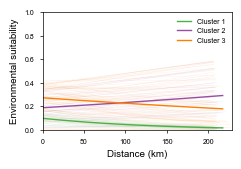

In [736]:
# from your_utils import mm2inch, color_list  # 假設你已定義
json_geo_path = os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "geographical_beta_params.json")

# 1. 讀取 JSON
with open(json_geo_path, "r") as f:
    geo_params = json.load(f)

fig, ax = plt.subplots(figsize=mm2inch(60, 40), 
                       gridspec_kw={'left': 0.15, 'right': 0.95, 
                                    'bottom': 0.2, 'top': 0.95})

def logistic(z):
    return 1 / (1 + np.exp(-z))

# ---------------------------------------------------------
# 先畫出「各物種」曲線 (alpha=0.1)  -- 這部分不變
# ---------------------------------------------------------
max_x_overall = 0.0
for i, species in enumerate(species_list_predict):
    info = geo_params[species]
    params_mu = np.array(info["params_mu"])
    x_min = info["x_min"]
    x_max = info["x_max"]
    y_min = info["y_min"]
    y_max = info["y_max"]
    eps   = info["epsilon"]

    if x_max > max_x_overall:
        max_x_overall = x_max
    
    x_line = np.linspace(x_min, x_max, 100)
    X_line = np.column_stack([np.ones_like(x_line), x_line])
    linear_pred = X_line @ params_mu
    mu_pred_norm = logistic(linear_pred)
    mu_pred = ((mu_pred_norm - eps) / (1 - 2*eps)) * (y_max - y_min) + y_min
    
    cluster_idx = cluster_label[i]  # 1,2,3
    c_idx = cluster_idx - 1
    ax.plot(x_line, mu_pred, color=color_list[c_idx], alpha=0.1, linewidth=0.3)

# ---------------------------------------------------------
# 三個群集的平均線
# ---------------------------------------------------------
with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'geographical_beta_params_cluster.json'), 'r') as f:
    geo_params_cluster = json.load(f)

x_min_cluster = max([p['x_min'] for p in geo_params_cluster.values()])
x_max_cluster = min([p['x_max'] for p in geo_params_cluster.values()])

for cluster in range(1, 4):
    info = geo_params_cluster[str(cluster)]    
    params_mu = np.array(info["params_mu"])
    phi = np.array(info["params_phi"])
    x_min = info["x_min"]
    x_max = info["x_max"]
    y_min = info["y_min"]
    y_max = info["y_max"]
    eps   = info["epsilon"]    
    
    x_line = np.linspace(x_min_cluster, x_max_cluster)
    X_line = np.column_stack([np.ones_like(x_line), x_line])
    linear_pred = X_line @ params_mu
    mu_pred_norm = logistic(linear_pred)
    mu_pred = ((mu_pred_norm - eps) / (1 - 2*eps)) * (y_max - y_min) + y_min

#     alpha_param = mu_pred_norm * phi
#     beta_param = (1 - mu_pred_norm) * phi
    
#     from scipy.stats import beta
#     lower_bound_norm = beta.ppf(0.025, alpha_param, beta_param)
#     upper_bound_norm = beta.ppf(0.975, alpha_param, beta_param)
#     lower_original = (lower_bound_norm - epsilon) / (1 - 2 * epsilon) * (y_max - y_min) + y_min
#     upper_original = (upper_bound_norm - epsilon) / (1 - 2 * epsilon) * (y_max - y_min) + y_min
    
    
    color_idx = cluster - 1
    ax.plot(
        x_line, mu_pred,
        color=color_list[color_idx],
        alpha=1.0,
        linewidth=1,
        label=f'Cluster {cluster}'
    )
#     plt.fill_between(x_line, lower_original, upper_original, alpha=0.6, label='95% CI', color = color_list[color_idx])

# ---------------------------------------------------------
# 外觀調整
# ---------------------------------------------------------
ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=0, right=max_x_overall)
ax.set_ylabel('Environmental suitability')
ax.set_xlabel('Distance (km)')
ax.legend(loc='best')

out_fig = os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'geo_beta_reg.pdf')
plt.savefig(out_fig, dpi=500, transparent=True)
plt.show()

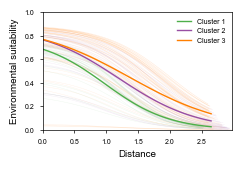

In [738]:
# from your_utils import mm2inch, color_list  # 假設你已定義
json_eco_path = os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "ecological_beta_params.json")

# 1. 讀取 JSON
with open(json_eco_path, "r") as f:
    eco_params = json.load(f)

fig, ax = plt.subplots(figsize=mm2inch(60, 40), 
                       gridspec_kw={'left': 0.15, 'right': 0.95, 
                                    'bottom': 0.2, 'top': 0.95})

def logistic(z):
    return 1 / (1 + np.exp(-z))

# ---------------------------------------------------------
# 先畫出「各物種」曲線 (alpha=0.1)  -- 這部分不變
# ---------------------------------------------------------
max_x_overall = 0.0
for i, species in enumerate(species_list_predict):
    info = eco_params[species]
    params_mu = np.array(info["params_mu"])
    x_min = info["x_min"]
    x_max = info["x_max"]
    y_min = info["y_min"]
    y_max = info["y_max"]
    eps   = info["epsilon"]

    if x_max > max_x_overall:
        max_x_overall = x_max
    
    x_line = np.linspace(x_min, x_max, 100)
    X_line = np.column_stack([np.ones_like(x_line), x_line])
    linear_pred = X_line @ params_mu
    mu_pred_norm = logistic(linear_pred)
    mu_pred = ((mu_pred_norm - eps) / (1 - 2*eps)) * (y_max - y_min) + y_min
    
    cluster_idx = cluster_label[i]  # 1,2,3
    c_idx = cluster_idx - 1
    ax.plot(x_line, mu_pred, color=color_list[c_idx], alpha=0.1, linewidth=0.3)

# ---------------------------------------------------------
# 三個群集的平均線
# ---------------------------------------------------------
with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'ecological_beta_params_cluster.json'), 'r') as f:
    eco_params_cluster = json.load(f)

x_min_cluster = max([p['x_min'] for p in eco_params_cluster.values()])
x_max_cluster = min([p['x_max'] for p in eco_params_cluster.values()])

for cluster in range(1, 4):
    info = eco_params_cluster[str(cluster)]    
    params_mu = np.array(info["params_mu"])
    phi = np.array(info["params_phi"])
    x_min = info["x_min"]
    x_max = info["x_max"]
    y_min = info["y_min"]
    y_max = info["y_max"]
    eps   = info["epsilon"]    
    
    x_line = np.linspace(x_min_cluster, x_max_cluster)
    X_line = np.column_stack([np.ones_like(x_line), x_line])
    linear_pred = X_line @ params_mu
    mu_pred_norm = logistic(linear_pred)
    mu_pred = ((mu_pred_norm - eps) / (1 - 2*eps)) * (y_max - y_min) + y_min

#     alpha_param = mu_pred_norm * phi
#     beta_param = (1 - mu_pred_norm) * phi
    
#     from scipy.stats import beta
#     lower_bound_norm = beta.ppf(0.025, alpha_param, beta_param)
#     upper_bound_norm = beta.ppf(0.975, alpha_param, beta_param)
#     lower_original = (lower_bound_norm - epsilon) / (1 - 2 * epsilon) * (y_max - y_min) + y_min
#     upper_original = (upper_bound_norm - epsilon) / (1 - 2 * epsilon) * (y_max - y_min) + y_min
    
    
    color_idx = cluster - 1
    ax.plot(
        x_line, mu_pred,
        color=color_list[color_idx],
        alpha=1.0,
        linewidth=1,
        label=f'Cluster {cluster}'
    )
#     plt.fill_between(x_line, lower_original, upper_original, alpha=0.6, label='95% CI', color = color_list[color_idx])

# ---------------------------------------------------------
# 外觀調整
# ---------------------------------------------------------
ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=0, right=max_x_overall)
ax.set_ylabel('Environmental suitability')
ax.set_xlabel('Distance')
ax.legend(loc='best')

out_fig = os.path.join(plot_path_ecogeo_basedonDeepSDMpred, 'eco_beta_reg.pdf')
plt.savefig(out_fig, dpi=500, transparent=True)
plt.show()

# 選幾個物種畫，一張一張存

In [739]:
with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "geographical_beta_params.json"), "r") as f:
    geo_params = json.load(f)
with open(os.path.join(plot_path_ecogeo_basedonDeepSDMpred, "ecological_beta_params.json"), "r") as f:
    eco_params = json.load(f)

In [740]:
color_list = ['#4daf4a', '#984ea3', '#ff7f00']

In [741]:
[create_folder(os.path.join(plot_path_subplots, f'Fig{i+1}')) for i in range(6)]

[None, None, None, None, None, None]

In [742]:
species_to_print = ['Yuhina_brunneiceps', 'Psilopogon_nuchalis', 'Locustella_alishanensis', 'Gallinula_chloropus']

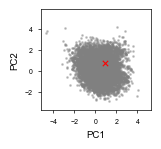

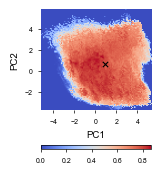

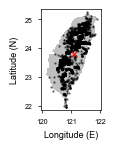

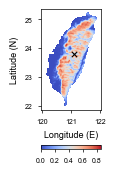

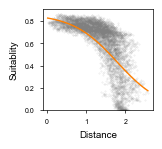

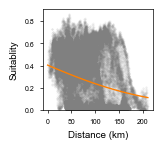

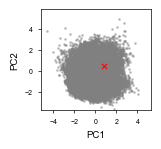

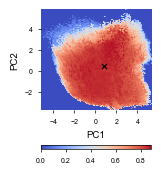

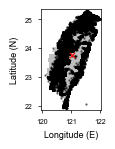

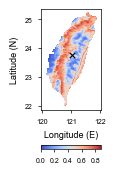

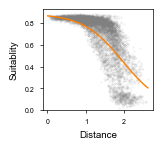

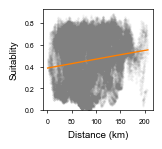

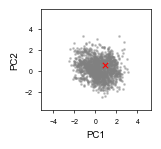

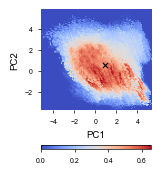

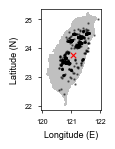

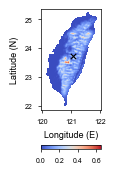

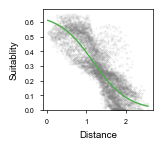

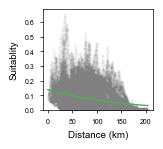

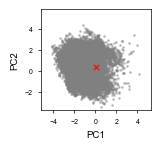

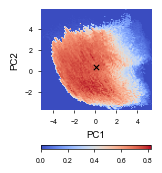

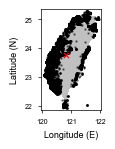

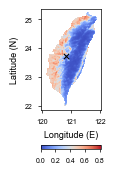

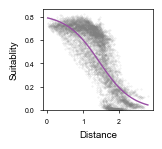

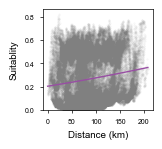

In [747]:
# Select which PC-axconcatould be plotted
x_pca = 1
y_pca = 2
niche_rst_size = 100
extent = [extent_info[f'PC{x_pca:02d}_extent_min'], 
          extent_info[f'PC{x_pca:02d}_extent_max'], 
          extent_info[f'PC{y_pca:02d}_extent_min'], 
          extent_info[f'PC{y_pca:02d}_extent_max']]

df_spearman = pd.DataFrame({'center_type': [], 'species': [], 'rho': [], 'p': []})

# 創建所有像素的網格坐標 (僅執行一次)
x_indices = np.where(extent_binary == 1)[1]
y_indices = np.where(extent_binary == 1)[0]

# 使用 rasterio 的批量處理一次性將像素索引轉換為經緯度
lon_lat_pairs = [xy(transform, y, x) for y, x in zip(y_indices, x_indices)]
lons, lats = zip(*lon_lat_pairs)
lons = np.array(lons)
lats = np.array(lats)

for species in species_to_print:
#     species = 'Acridotheres_cristatellus'
    x_all = []
    y_all = []

    # 找到所有的訓練時間點
    for time in date_list_predict:
        img_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        
        # 讀取 TIFF 圖像
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
        
        # 找到所有值為1的像素位置
        y_coords = np.where(img == 1)[0]
        x_coords = np.where(img == 1)[1]
        
        # 將 x 和 y 坐標分別添加到列表中
        x_all.extend(x_coords)
        y_all.extend(y_coords)

    # 計算 x 和 y 坐標的平均值，即為重心
    x_center_real = np.mean(x_all)
    y_center_real = np.mean(y_all)

    # 使用仿射變換矩陣將重心像素坐標轉換為地理坐標
    lon_center_real, lat_center_real = rasterio.transform.xy(transform, y_center_real, x_center_real, offset='center')

    img_sum = None  # 用於累加所有時間點的圖像

    with h5py.File(deepsdm_h5_path.replace('[SPECIES]', species), 'r') as hf:
        for date in date_list_predict:
            if img_sum is None:
                img_sum = hf[date][:].copy()
            else:
                img_sum = np.maximum(img_sum, hf[date][:].copy())
    
    # 儲存影像
    metadata = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,  # Number of bands
        "dtype": "float64",
        "crs": crs,
        "transform": transform,
    }   
    
    # 計算每個像素與地理重心之間的距離，使用批量化的 numpy 操作
    lon_center, lat_center = rasterio.transform.xy(transform, 
                                                   (np.where(~np.isnan(img_sum))[0] * img_sum[~np.isnan(img_sum)]).sum() / img_sum[~np.isnan(img_sum)].sum(), 
                                                   (np.where(~np.isnan(img_sum))[1] * img_sum[~np.isnan(img_sum)]).sum() / img_sum[~np.isnan(img_sum)].sum(), 
                                                   offset='center')    
    distances_all = haversine(lats, lons, lat_center, lon_center)

    # 平展 img_sum 以與 distances_all 一一對應
    cell_values_all = img_sum[~np.isnan(img_sum)].flatten()
    
    # 統計
    rho_geo, p_geo = scipy.stats.spearmanr(distances_all, cell_values_all)

    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))
    df_species = pd.concat([df_species, df_grid], axis = 1)
    
    with h5py.File(os.path.join(plot_path_nichespace_h5, f'{species}.h5'), 'r') as hf:
        nichespace_deepsdm = hf['deepsdm_all_season_max'][:]

    # calculate the negative regression of every cell of 2d-niche space to the niche center
    # 计算每个单元格的宽度和高度
    cell_width = (extent[1] - extent[0]) / nichespace_deepsdm.shape[1]
    cell_height = (extent[3] - extent[2]) / nichespace_deepsdm.shape[0]

    # 遍历每个单元格以计算中心点坐标
    coordinates_values = {'center_x': [], 'center_y': [], 'value_deepsdm': []}
    for i in range(niche_rst_size):
        for j in range(niche_rst_size):
            coordinates_values['center_x'].append(extent[0] + j * cell_width + cell_width / 2)  #center_x
            coordinates_values['center_y'].append(extent[3] - i * cell_height - cell_height / 2) # center_y
            coordinates_values['value_deepsdm'].append(nichespace_deepsdm[i, j])  # value_deepsdm

    df_cor = pd.DataFrame(coordinates_values).query('value_deepsdm > 0').reset_index(drop = True)    
    df_cor_only = df_cor.loc[df_cor['value_deepsdm'] > 0, ['center_x', 'center_y']].reset_index(drop = True)

    # 假設這是整個數據集的協方差矩陣
    cov_matrix = np.cov(df_cor_only, rowvar=False)

    # 計算協方差矩陣的逆矩陣
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # 計算加權的中心
    center_x = np.multiply(np.array(coordinates_values['center_x']), np.array(coordinates_values['value_deepsdm'])).sum() / np.array(coordinates_values['value_deepsdm']).sum()
    center_y = np.multiply(np.array(coordinates_values['center_y']), np.array(coordinates_values['value_deepsdm'])).sum() / np.array(coordinates_values['value_deepsdm']).sum()
    center = np.array([center_x, center_y])

    # 計算 Mahalanobis 距離
    df_cor['distance_mah'] = df_cor_only.apply(lambda row: distance.mahalanobis(row, center, inv_cov_matrix), axis=1)    
    condition_deepsdm = df_cor['value_deepsdm'] > 0
    rho_eco, p_eco = scipy.stats.spearmanr(df_cor['distance_mah'][condition_deepsdm], df_cor['value_deepsdm'][condition_deepsdm])        
        
        
        
    # Fig1
    fig, ax = plt.subplots(figsize = mm2inch(40, 40), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})
    for d in date_list_train:
        if f'occ_{species}_{d}' in df_species:
            i_p = df_species[f'occ_{species}_{d}'] == 1
            ax.scatter(df_env_value[f'PC{x_pca:02d}_{d}'][i_p], df_env_value[f'PC{y_pca:02d}_{d}'][i_p], c = 'grey', alpha = 0.4, s = 1)
    xlims = [extent[0], extent[1]]
    ylims = [extent[2], extent[3]]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_aspect(1)  # 計算x和y的比例，並設置為等比例
    ax.scatter(center[0], center[1], c = 'red', s = 15, marker = 'x', linewidths = 0.8)
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    ax.set_xticks([-4, -2, 0, 2, 4])
    plt.savefig(os.path.join(plot_path_subplots, 'Fig1', f'Fig1_{species}.pdf'), dpi = 500, transparent = True)    
    plt.show()
    

    
    # Fig2 
    fig, ax = plt.subplots(figsize = mm2inch(40, 50), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.12, 'top': 1-0.05/1.25})
    ax_imshow = ax.imshow(nichespace_deepsdm, cmap = 'coolwarm', extent = extent)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    ax.set_xticks([-4, -2, 0, 2, 4])
     
#     ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])))  # 計算x和y的比例，並設置為等比例
    ax_pos = ax.get_position()
    cbar_ax = fig.add_axes([ax_pos.x0, 
                            ax_pos.y0 - ax_pos.height*0.38, 
                            ax_pos.width*1, 
                            ax_pos.height*0.04])
    cbar = fig.colorbar(ax_imshow, ax = ax, orientation='horizontal', cax = cbar_ax)
    ax.scatter(center[0], center[1], c = 'black', s = 15, marker = 'x', linewidths=0.8)
#     cbar.ax.tick_params(labelsize=10, which='both')  # 調整刻度標籤字體大小

    plt.savefig(os.path.join(plot_path_subplots, 'Fig2', f'Fig2_{species}.pdf'), dpi = 500, transparent = True)
    plt.show()


    # Fig 3
    fig, ax = plt.subplots(figsize = mm2inch(40, 40), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.95-28/1.0921832795998423/40, 'top': 0.95})
    ax_imshow = ax.imshow(np.where(extent_binary == 1, extent_binary, np.nan), cmap = ListedColormap(['silver']), extent = extent_binary_extent)
    lon_all, lat_all = rasterio.transform.xy(transform, y_all, x_all, offset='center')
    ax.scatter(lon_all, lat_all, c = 'black', s = 0.5, alpha = 0.5)
    ax.scatter(lon_center, lat_center, c = 'red', s = 15, marker = 'x', linewidths = 0.8)
    ax.set_ylabel('Latitude (N)', size = 6.5)
    ax.set_xlabel('Longitude (E)', size = 6.5)
    ax.set_xticks([120, 121, 122])
    ax.yaxis.set_major_locator(MaxNLocator(integer = True))  # Y 軸只顯示整數
    ax.xaxis.set_major_locator(MaxNLocator(integer = True))
    ax.set_aspect(1)
    plt.savefig(os.path.join(plot_path_subplots, 'Fig3', f'Fig3_{species}.pdf'), dpi = 500, transparent = True)
    plt.show()


    # Fig 4
    fig, ax = plt.subplots(figsize = mm2inch(40, 50), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.96-28/1.0921832795998423/50, 'top': 0.96})
    ax_imshow = ax.imshow(img_sum, cmap='coolwarm', extent = extent_binary_extent, vmin = 0)
    ax.set_ylabel('Latitude (N)', size = 6.5)
    ax.set_xlabel('Longitude (E)', size = 6.5)
    ax.set_xticks([120, 121, 122])
    ax.scatter(lon_center, lat_center, c = 'black', s = 15, marker = 'x', linewidths = 0.8)
    ax_pos = ax.get_position()
    cbar_ax = fig.add_axes([ax_pos.x0, 
                            ax_pos.y0 - ax_pos.height*0.38, 
                            ax_pos.width*1, 
                            ax_pos.height*0.04])
    cbar = fig.colorbar(ax_imshow, ax=ax, orientation='horizontal', cax=cbar_ax)
    vmin, vmax = cbar.vmin, cbar.vmax
    # 使用 numpy 來創建從 vmin 到 vmax，間隔為 0.2 的刻度
    ticks = np.arange(np.floor(vmin/0.2)*0.2, np.floor(vmax/0.2)*0.2 + 0.2, 0.2)
    cbar.set_ticks(ticks)    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Y 軸只顯示整數
#     cbar.ax.tick_params(labelsize=10, which='both')  # 調整刻度標籤字體大小
    
    plt.savefig(os.path.join(plot_path_subplots, 'Fig4', f'Fig4_{species}.pdf'), dpi = 500, transparent = True)
    plt.show()

    

    
    # Fig 5

    fig, ax = plt.subplots(figsize = mm2inch(40, 40), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})
    ax.scatter(df_cor['distance_mah'][condition_deepsdm], df_cor['value_deepsdm'][condition_deepsdm], alpha = 0.2, color = 'grey', s = 0.1)
    ax.set_ylabel('Suitablity')
    ax.set_xlabel('Distance')
    ax.set_ylim(bottom=0)
#     ax_pos = ax.get_position()
#     fig.text(x = ax_pos.x1 - ax_pos.width * 0.02, 
#              y = ax_pos.y1 - ax_pos.height * 0.02, 
#              s = rf'$\rho$={rho_eco:.2f}{get_significance_stars(p_eco)}', 
#              fontsize=20, ha = 'right', va = 'top')
    
    info = eco_params[species]
    params_mu = np.array(info["params_mu"])
    x_min = info["x_min"]
    x_max = info["x_max"]
    y_min = info["y_min"]
    y_max = info["y_max"]
    eps   = info["epsilon"]
    
    x_line = np.linspace(x_min, x_max, 100)
    X_line = np.column_stack([np.ones_like(x_line), x_line])
    linear_pred = X_line @ params_mu
    mu_pred_norm = logistic(linear_pred)
    mu_pred = ((mu_pred_norm - eps) / (1 - 2*eps)) * (y_max - y_min) + y_min
    
    cluster_idx = cluster_label[species_list_predict.index(species)]  # 1,2,3
    c_idx = cluster_idx - 1
    ax.plot(x_line, mu_pred, color=color_list[c_idx], linewidth=1)
    
    ax.set_box_aspect(1/abs((extent[1] - extent[0]) / (extent[3] - extent[2])))
    plt.savefig(os.path.join(plot_path_subplots, 'Fig5', f'Fig5_{species}.pdf'), dpi = 500, transparent = True)
    plt.savefig(os.path.join(plot_path_subplots, 'Fig5', f'Fig5_{species}.png'), dpi = 2000, transparent = True)
    plt.show()

    
    # Fig 6
    fig, ax = plt.subplots(figsize = mm2inch(40, 40), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})
    ax.scatter(distances_all, cell_values_all, alpha = 0.1, color = 'grey', s = 0.1)
    ax.set_ylabel('Suitablity')
    ax.set_xlabel('Distance (km)')
    ax.set_ylim(bottom=0)
#     ax_pos = ax.get_position()
#     fig.text(x = ax_pos.x1 - ax_pos.width * 0.02, 
#              y = ax_pos.y1 - ax_pos.height * 0.02, 
#              s = rf'$\rho$={rho_geo:.2f}{get_significance_stars(p_geo)}', 
#              fontsize=20, 
#              ha = 'right', 
#              va = 'top')
    info = geo_params[species]
    params_mu = np.array(info["params_mu"])
    x_min = info["x_min"]
    x_max = info["x_max"]
    y_min = info["y_min"]
    y_max = info["y_max"]
    eps   = info["epsilon"]
    
    x_line = np.linspace(x_min, x_max, 100)
    X_line = np.column_stack([np.ones_like(x_line), x_line])
    linear_pred = X_line @ params_mu
    mu_pred_norm = logistic(linear_pred)
    mu_pred = ((mu_pred_norm - eps) / (1 - 2*eps)) * (y_max - y_min) + y_min
    
    cluster_idx = cluster_label[species_list_predict.index(species)]  # 1,2,3
    c_idx = cluster_idx - 1
    ax.plot(x_line, mu_pred, color=color_list[c_idx], linewidth=1)
    
    ax.set_box_aspect(1/abs((extent[1] - extent[0]) / (extent[3] - extent[2])))
    plt.savefig(os.path.join(plot_path_subplots, 'Fig6', f'Fig6_{species}.pdf'), dpi = 500, transparent = True)
    plt.savefig(os.path.join(plot_path_subplots, 'Fig6', f'Fig6_{species}.png'), dpi = 2000, transparent = True)
#     break

### clt

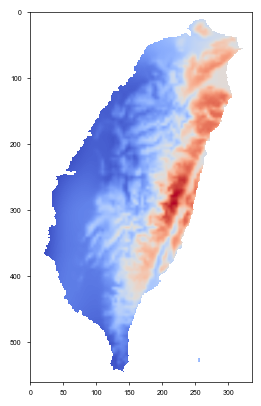

In [440]:
env_avg = None
for file in [env_inf['info']['clt'][date]['tif_span_avg'] for date in date_list_predict]:
    with rasterio.open(os.path.join(env_inf['dir_base'], file), 'r') as f:
        env_img = f.read(1)
        
    env_img = np.where(env_img == -9999, np.nan, env_img)
    if env_avg is not None:
        env_avg = env_avg + env_img
    else:
        env_avg = env_img
env_avg = env_avg / len(date_list_predict)
plt.imshow(env_avg, cmap = 'coolwarm')

0.12722433


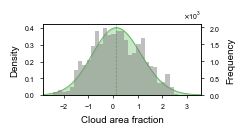

-0.38104334


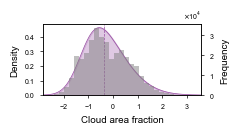

-0.13941677


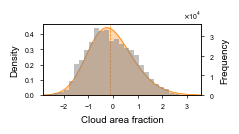

In [682]:
env_plot = 'clt'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()
    env_value_cluster = []

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        if len(i_threshold) >= 1000:
            sampled_indices = np.random.choice(i_threshold, size=1000, replace=False)
        else:
            needed_extra = 1000 - len(i_threshold)
            extra_indices = np.random.choice(i_threshold, size=needed_extra, replace=True)
            sampled_indices = np.concatenate([i_threshold, extra_indices])

        env_value = env_value[i_threshold]
        env_value_cluster.append(env_value)

    env_value_cluster = np.concatenate(env_value_cluster)

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value_cluster)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value_cluster)
    print(median_val)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster-1], linewidth=0.5)

    jitter_strength = (env_max - env_min) * 0.005
    env_jittered = env_value_cluster + np.random.uniform(-jitter_strength, jitter_strength, size=env_value_cluster.shape)

#     sns.rugplot(env_jittered, ax=ax_pdf, height=0.05, linewidth=0.04, alpha=0.03, color=color_list[cluster-1])

    ax_pdf.set_xlabel('Cloud area fraction')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}{cluster}.pdf'), dpi=500, transparent=True)
    plt.show()


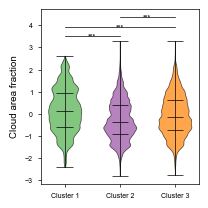

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=5386.1278603814635, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1467.5009046972455, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=9132.808621834502, pvalue=0.0)}


In [840]:
env_plot = 'clt'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

# Prepare storage for environmental values per cluster
cluster_env_values = {1: [], 2: [], 3: []}

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        env_value = env_value[i_threshold]
        cluster_env_values[cluster].extend(env_value)

# 執行 Kruskal-Wallis 檢定
pairwise_results = {
    'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
    'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
    'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
}

# 繪製 violin plot
fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                        showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

# 設定 violin plot 顏色
for i, body in enumerate(violin['bodies']):
    body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
    body.set_alpha(0.7)  # 調整透明度
    body.set_edgecolor('black')
    body.set_linewidth(0.5)
for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
    c_element.set_linewidth(0.5)
    c_element.set_color('black')



# 設定標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_ylabel('Cloud area fraction')

# 計算標註位置
y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
y_step = (y_max - y_min) * 0.07  # 每條線間的間距

# 兩兩組合的比較位置
positions = [(1, 2), (1, 3), (2, 3)]
y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

# 加入顯著性標註與橫線
for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
    p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
    significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

    x1, x2 = pos1, pos2
    ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
    ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

# 儲存圖表
plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
# 顯示圖表
plt.show()

# 返回檢定結果
print(pairwise_results)

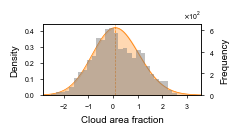

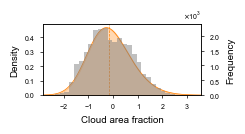

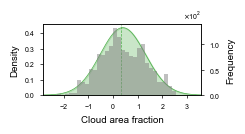

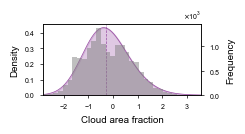

In [649]:
env_plot = 'clt'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for species in species_to_print:
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

    occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
    env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

    mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
    occ_value = occ_value[mask]
    env_value = env_value[mask]

    i_threshold = np.where(occ_value == 1)[0]
    env_value = env_value[i_threshold]

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster_label[species_list_predict.index(species)]-1], linewidth=0.5)

    ax_pdf.set_xlabel('Cloud area fraction')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_{species}.pdf'), dpi=500, transparent=True)
    plt.show()


### landcoverPC1

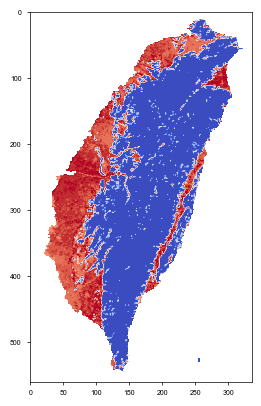

In [444]:
env_avg = None
for file in [env_inf['info']['landcover_PC00'][date]['tif_span_avg'] for date in date_list_predict]:
    with rasterio.open(os.path.join(env_inf['dir_base'], file), 'r') as f:
        env_img = f.read(1)
        
    env_img = np.where(env_img == -9999, np.nan, env_img)
    if env_avg is not None:
        env_avg = env_avg + env_img
    else:
        env_avg = env_img
env_avg = env_avg / len(date_list_predict)
plt.imshow(env_avg, cmap = 'coolwarm')

### 所有物種

-0.39305097


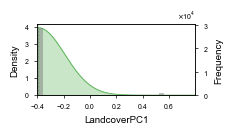

0.6619131


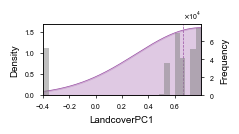

-0.39305097


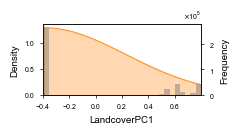

In [683]:
env_plot = 'landcover_PC00'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()
    env_value_cluster = []

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        if len(i_threshold) >= 1000:
            sampled_indices = np.random.choice(i_threshold, size=1000, replace=False)
        else:
            needed_extra = 1000 - len(i_threshold)
            extra_indices = np.random.choice(i_threshold, size=needed_extra, replace=True)
            sampled_indices = np.concatenate([i_threshold, extra_indices])

        env_value = env_value[i_threshold]
        env_value_cluster.append(env_value)

    env_value_cluster = np.concatenate(env_value_cluster)

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value_cluster)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value_cluster)
    print(median_val)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster-1], linewidth=0.5)

    jitter_strength = (env_max - env_min) * 0.005
    env_jittered = env_value_cluster + np.random.uniform(-jitter_strength, jitter_strength, size=env_value_cluster.shape)

#     sns.rugplot(env_jittered, ax=ax_pdf, height=0.05, linewidth=0.04, alpha=0.03, color=color_list[cluster-1])

    ax_pdf.set_xlabel('LandcoverPC1')

    ax_pdf.set_xlim(env_min-0.01, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}{cluster}.pdf'), dpi=500, transparent=True)
    plt.show()


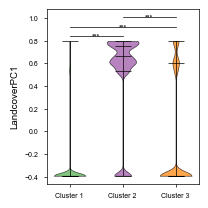

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=57696.40325347088, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=11283.040652407186, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=158096.77800426504, pvalue=0.0)}


In [841]:
env_plot = 'landcover_PC00'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

# Prepare storage for environmental values per cluster
cluster_env_values = {1: [], 2: [], 3: []}

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        env_value = env_value[i_threshold]
        cluster_env_values[cluster].extend(env_value)

# 執行 Kruskal-Wallis 檢定
pairwise_results = {
    'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
    'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
    'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
}

# 繪製 violin plot
fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                        showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

# 設定 violin plot 顏色
for i, body in enumerate(violin['bodies']):
    body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
    body.set_alpha(0.7)  # 調整透明度
    body.set_edgecolor('black')
    body.set_linewidth(0.5)
for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
    c_element.set_linewidth(0.5)
    c_element.set_color('black')



# 設定標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_ylabel('LandcoverPC1')

# 計算標註位置
y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
y_step = (y_max - y_min) * 0.07  # 每條線間的間距

# 兩兩組合的比較位置
positions = [(1, 2), (1, 3), (2, 3)]
y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

# 加入顯著性標註與橫線
for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
    p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
    significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

    x1, x2 = pos1, pos2
    ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
    ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

# 儲存圖表
plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
# 顯示圖表
plt.show()

# 返回檢定結果
print(pairwise_results)

### 個別物種

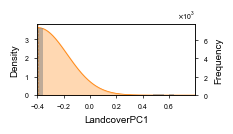

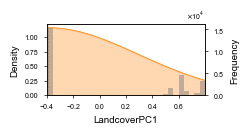

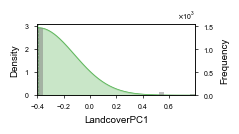

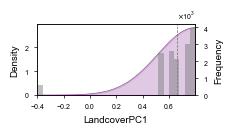

In [652]:
env_plot = 'landcover_PC00'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for species in species_to_print:
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

    occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
    env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

    mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
    occ_value = occ_value[mask]
    env_value = env_value[mask]

    i_threshold = np.where(occ_value == 1)[0]
    env_value = env_value[i_threshold]

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster_label[species_list_predict.index(species)]-1], linewidth=0.5)

    ax_pdf.set_xlabel('LandcoverPC1')

    ax_pdf.set_xlim(env_min-0.01, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_{species}.pdf'), dpi=500, transparent=True)
    plt.show()


### hurs

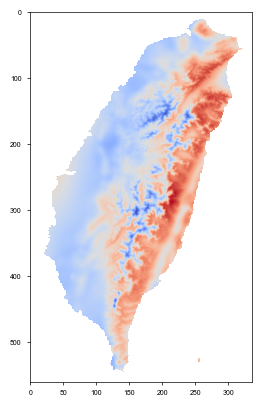

In [448]:
env_avg = None
for file in [env_inf['info']['hurs'][date]['tif_span_avg'] for date in date_list_predict]:
    with rasterio.open(os.path.join(env_inf['dir_base'], file), 'r') as f:
        env_img = f.read(1)
        
    env_img = np.where(env_img == -9999, np.nan, env_img)
    if env_avg is not None:
        env_avg = env_avg + env_img
    else:
        env_avg = env_img
env_avg = env_avg / len(date_list_predict)
plt.imshow(env_avg, cmap = 'coolwarm')

-0.62417644


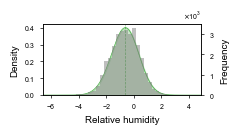

-0.49514565


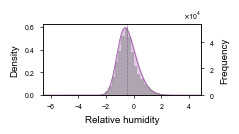

-0.22866534


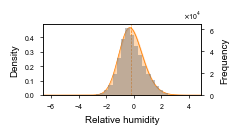

In [684]:
env_plot = 'hurs'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()
    env_value_cluster = []

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        if len(i_threshold) >= 1000:
            sampled_indices = np.random.choice(i_threshold, size=1000, replace=False)
        else:
            needed_extra = 1000 - len(i_threshold)
            extra_indices = np.random.choice(i_threshold, size=needed_extra, replace=True)
            sampled_indices = np.concatenate([i_threshold, extra_indices])

        env_value = env_value[i_threshold]
        env_value_cluster.append(env_value)

    env_value_cluster = np.concatenate(env_value_cluster)

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value_cluster)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value_cluster)
    print(median_val)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster-1], linewidth=0.5)

    jitter_strength = (env_max - env_min) * 0.005
    env_jittered = env_value_cluster + np.random.uniform(-jitter_strength, jitter_strength, size=env_value_cluster.shape)

#     sns.rugplot(env_jittered, ax=ax_pdf, height=0.05, linewidth=0.04, alpha=0.03, color=color_list[cluster-1])

    ax_pdf.set_xlabel('Relative humidity')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}{cluster}.pdf'), dpi=500, transparent=True)
    plt.show()


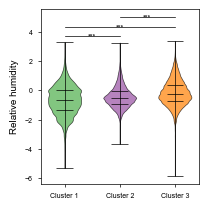

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=1166.2369510830388, pvalue=1.3275131890471264e-255), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=6251.49651775398, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=20353.221149592235, pvalue=0.0)}


In [842]:
env_plot = 'hurs'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

# Prepare storage for environmental values per cluster
cluster_env_values = {1: [], 2: [], 3: []}

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        env_value = env_value[i_threshold]
        cluster_env_values[cluster].extend(env_value)

# 執行 Kruskal-Wallis 檢定
pairwise_results = {
    'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
    'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
    'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
}

# 繪製 violin plot
fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                        showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

# 設定 violin plot 顏色
for i, body in enumerate(violin['bodies']):
    body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
    body.set_alpha(0.7)  # 調整透明度
    body.set_edgecolor('black')
    body.set_linewidth(0.5)
for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
    c_element.set_linewidth(0.5)
    c_element.set_color('black')



# 設定標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_ylabel('Relative humidity')

# 計算標註位置
y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
y_step = (y_max - y_min) * 0.07  # 每條線間的間距

# 兩兩組合的比較位置
positions = [(1, 2), (1, 3), (2, 3)]
y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

# 加入顯著性標註與橫線
for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
    p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
    significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

    x1, x2 = pos1, pos2
    ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
    ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

# 儲存圖表
plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
# 顯示圖表
plt.show()

# 返回檢定結果
print(pairwise_results)

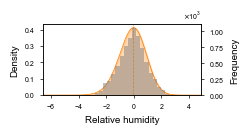

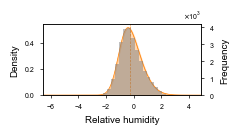

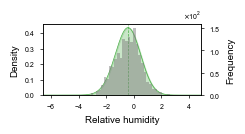

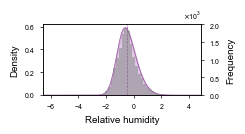

In [654]:
env_plot = 'hurs'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for species in species_to_print:
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

    occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
    env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

    mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
    occ_value = occ_value[mask]
    env_value = env_value[mask]

    i_threshold = np.where(occ_value == 1)[0]
    env_value = env_value[i_threshold]

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster_label[species_list_predict.index(species)]-1], linewidth=0.5)

    ax_pdf.set_xlabel('Relative humidity')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_{species}.pdf'), dpi=500, transparent=True)
    plt.show()


In [ ]:
s

### 其他環境因子的violin plot

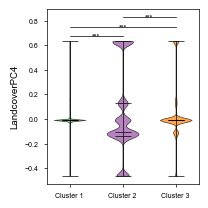

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=3379.095822119466, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=33.4830502370663, pvalue=7.1887748010620206e-09), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=20049.18535329355, pvalue=0.0)}


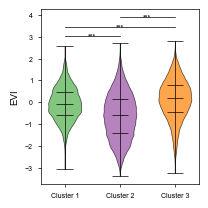

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=8652.677266201448, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1732.0701511022764, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=87442.43331923627, pvalue=0.0)}


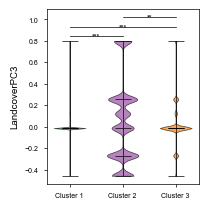

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=252.4041625265468, pvalue=7.768199938564097e-57), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=287.8945121537227, pvalue=1.4299759389494793e-64), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=9.923132463479384, pvalue=0.0016321436863424388)}


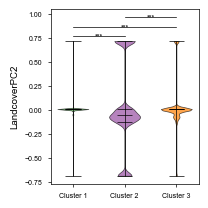

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=11526.39494303439, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1106.0778050572271, pvalue=1.577290968081921e-242), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=43177.32760800824, pvalue=0.0)}


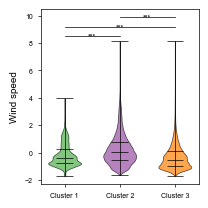

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=4081.242581977128, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1456.4252967905452, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=54659.72627381351, pvalue=0.0)}


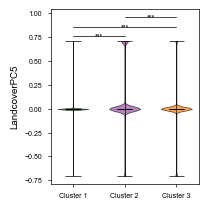

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=6736.10740808144, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1789.0985286176951, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=15611.483410041415, pvalue=0.0)}


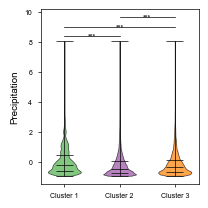

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=3477.7976206619905, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1313.8514221497655, pvalue=1.1043981475048816e-287), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=4009.1583682637806, pvalue=0.0)}


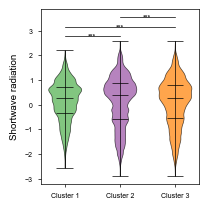

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=67.57186820375213, pvalue=2.031455219471633e-16), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=13.73938014726967, pvalue=0.00021000478821476688), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=764.5412075120629, pvalue=2.7647738113394004e-168)}


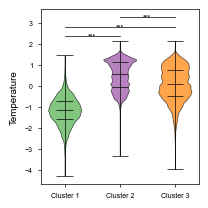

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=70591.36487831724, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=50315.34919496231, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=46974.680438981566, pvalue=0.0)}


In [853]:
for env_plot in list(set(env_list) - set(['hurs', 'landcover_PC00', 'clt'])):
    env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
    env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

    # Prepare storage for environmental values per cluster
    cluster_env_values = {1: [], 2: [], 3: []}

    for cluster in [1, 2, 3]:
        species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

        for species in species_list_cluster:
            df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

            occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
            env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

            mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
            occ_value = occ_value[mask]
            env_value = env_value[mask]

            i_threshold = np.where(occ_value == 1)[0]

            env_value = env_value[i_threshold]
            cluster_env_values[cluster].extend(env_value)

    # 執行 Kruskal-Wallis 檢定
    pairwise_results = {
        'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
        'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
        'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
    }

    # 繪製 violin plot
    fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
    violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                            showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

    # 設定 violin plot 顏色
    for i, body in enumerate(violin['bodies']):
        body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
        body.set_alpha(0.7)  # 調整透明度
        body.set_edgecolor('black')
        body.set_linewidth(0.5)
    for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
        c_element.set_linewidth(0.5)
        c_element.set_color('black')



    # 設定標籤
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
    ax.set_ylabel(f'{env_list_change[env_plot]}')

    # 計算標註位置
    y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
    y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
    y_step = (y_max - y_min) * 0.07  # 每條線間的間距

    # 兩兩組合的比較位置
    positions = [(1, 2), (1, 3), (2, 3)]
    y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

    # 加入顯著性標註與橫線
    for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
        p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
        significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

        x1, x2 = pos1, pos2
        ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
        ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

    # 儲存圖表
    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
    # 顯示圖表
    plt.show()

    # 返回檢定結果
    print(pairwise_results)